In [60]:
%load_ext autoreload
%autoreload 2

from tqdm import tqdm
import pandas as pd
import numpy as np
import gzip
import json
import math
from datetime import datetime
import matplotlib.dates as mdates
from mpl_toolkits.mplot3d import Axes3D
from IPython.display import display
%matplotlib inline

from helper.rl_framework import *
from helper.rl_functions import *
from helper.orderbook_container import OrderbookContainer
from helper.manage_orderbooks_v2 import *
from helper.orderbook_trader import *
from Q_learning import QLearn

# Neural Network
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.optimizers import RMSprop

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [53]:
# filename = '../data/snapshots/orderbooks_USDT_BTC_range1.15_samplesNone_snapshot2017-01-11T17:19.dict'
filename = '3000orderbooks'
currency_pair = 'USDT_BTC'
offset = 240
orderbooks = load_orderbook_snapshot(infile=filename, first_line=offset, last_line=offset+240)  #, first_line=offset+0, last_line=offset+10)

print("Successfully loaded {} orderbooks from '{}'".format(len(orderbooks), filename))
print(orderbooks[0])

100%|██████████| 240/240 [00:11<00:00, 22.04it/s]

Loaded 240 orderbooks from file '3000orderbooks'.
Successfully loaded 240 orderbooks from '3000orderbooks'
OrderbookContainer from 2016-11-08T14:01
  522 bids (best: 708.9)
  397 asks (best: 709.63)
  kind: 'orderbook'


### Settings

In [54]:
V = 100  # trading volume
T = 4  # Time horizon: 10 periods -> P*T = 20 minutes
P = 5  # period length
print("V={}, T={}, P={}".format(V, T, P))

V=100, T=4, P=5


#### Split orderbook array into non-overlapping episodes

Episodes: 12, episode length: 20


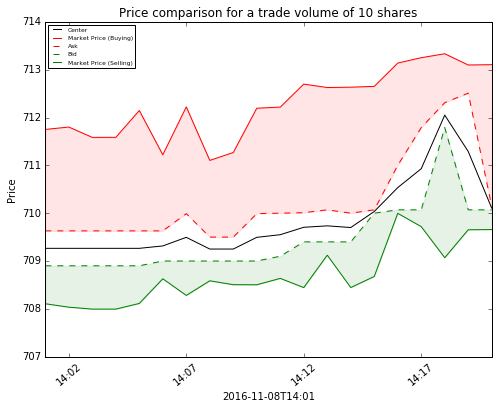

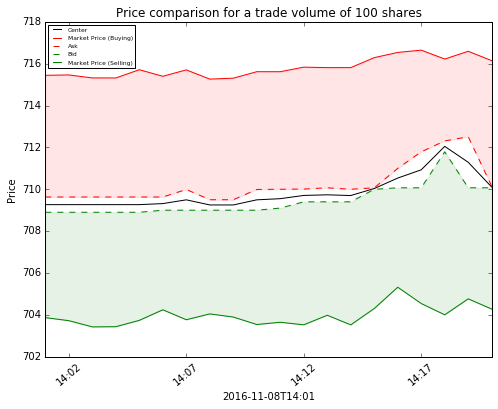

In [56]:
def create_episodes(orderbooks, episode_length):
    episode_windows = []
    for e in range(0, int(len(orderbooks) / episode_length)):
        window = [ob.copy() for ob in orderbooks[e*episode_length:(e+1)*episode_length]]

        # plot_episode(window, volume=V, outfile='graphs/episode_window{}'.format(e))
        episode_windows.append(window)
    return episode_windows

episode_windows = create_episodes(orderbooks, episode_length=T*P)

print("Episodes: {}, episode length: {}".format(len(episode_windows), len(episode_windows[0])))
plot_episode(episode_windows[0], volume=10)
plot_episode(episode_windows[0], volume=100)

In [5]:
STATE_DIM = 2
NUM_ACTIONS = 11
actions = list(np.linspace(-1, 9, num=NUM_ACTIONS))
print("available actions: {}".format(actions))

available actions: [-1.0, 0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0]


In [6]:
def round_custombase(val, *, base):
    return round(val / base) * base

round_custombase(12.43, base=5)

10

In [7]:
print(len(episode_windows))

24


  0%|          | 0/24 [00:00<?, ?it/s]

V: 100, H: 20, T: 4, I: 4, L: 11
actions: [-1.0, 0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0]
volumes_base: 25.0
volumes: [ 100.   75.   50.   25.]


/Users/axelperschmann/anaconda/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:227: RuntimeWarning: All-NaN axis encountered
  warnings.warn("All-NaN axis encountered", RuntimeWarning)
/Users/axelperschmann/anaconda/lib/python3.5/site-packages/mpl_toolkits/mplot3d/axes3d.py:2401: UserWarning: x, y, and z must be the same length.
  warnings.warn('x, y, and z must be the same length.')

  4%|▍         | 1/24 [00:05<02:03,  5.37s/it]

Successfully saved 'graphs/Q_function_4_action.pdf'
Successfully saved 'graphs/Q_function_4_Q.pdf'



  8%|▊         | 2/24 [00:11<02:00,  5.49s/it]

Successfully saved 'graphs/Q_function_4_action.pdf'
Successfully saved 'graphs/Q_function_4_Q.pdf'



 12%|█▎        | 3/24 [00:16<01:54,  5.44s/it]

Successfully saved 'graphs/Q_function_4_action.pdf'
Successfully saved 'graphs/Q_function_4_Q.pdf'



 17%|█▋        | 4/24 [00:23<01:55,  5.79s/it]

Successfully saved 'graphs/Q_function_4_action.pdf'
Successfully saved 'graphs/Q_function_4_Q.pdf'



 21%|██        | 5/24 [00:29<01:54,  6.04s/it]

Successfully saved 'graphs/Q_function_4_action.pdf'
Successfully saved 'graphs/Q_function_4_Q.pdf'



 25%|██▌       | 6/24 [00:35<01:50,  6.11s/it]

Successfully saved 'graphs/Q_function_4_action.pdf'
Successfully saved 'graphs/Q_function_4_Q.pdf'



 29%|██▉       | 7/24 [00:42<01:43,  6.11s/it]

Successfully saved 'graphs/Q_function_4_action.pdf'
Successfully saved 'graphs/Q_function_4_Q.pdf'



 33%|███▎      | 8/24 [00:48<01:41,  6.32s/it]

Successfully saved 'graphs/Q_function_4_action.pdf'
Successfully saved 'graphs/Q_function_4_Q.pdf'



 38%|███▊      | 9/24 [00:55<01:36,  6.42s/it]

Successfully saved 'graphs/Q_function_4_action.pdf'
Successfully saved 'graphs/Q_function_4_Q.pdf'



 42%|████▏     | 10/24 [01:03<01:36,  6.86s/it]

Successfully saved 'graphs/Q_function_4_action.pdf'
Successfully saved 'graphs/Q_function_4_Q.pdf'



 46%|████▌     | 11/24 [01:10<01:29,  6.92s/it]

Successfully saved 'graphs/Q_function_4_action.pdf'
Successfully saved 'graphs/Q_function_4_Q.pdf'



 50%|█████     | 12/24 [01:17<01:23,  6.95s/it]

Successfully saved 'graphs/Q_function_4_action.pdf'
Successfully saved 'graphs/Q_function_4_Q.pdf'



 54%|█████▍    | 13/24 [01:23<01:11,  6.51s/it]

Successfully saved 'graphs/Q_function_4_action.pdf'
Successfully saved 'graphs/Q_function_4_Q.pdf'



 58%|█████▊    | 14/24 [01:27<00:58,  5.88s/it]

Successfully saved 'graphs/Q_function_4_action.pdf'
Successfully saved 'graphs/Q_function_4_Q.pdf'



 62%|██████▎   | 15/24 [01:31<00:46,  5.20s/it]

Successfully saved 'graphs/Q_function_4_action.pdf'
Successfully saved 'graphs/Q_function_4_Q.pdf'



 67%|██████▋   | 16/24 [01:34<00:37,  4.71s/it]

Successfully saved 'graphs/Q_function_4_action.pdf'
Successfully saved 'graphs/Q_function_4_Q.pdf'



 71%|███████   | 17/24 [01:36<00:28,  4.01s/it]

Successfully saved 'graphs/Q_function_4_action.pdf'
Successfully saved 'graphs/Q_function_4_Q.pdf'



 75%|███████▌  | 18/24 [01:41<00:24,  4.10s/it]

Successfully saved 'graphs/Q_function_4_action.pdf'
Successfully saved 'graphs/Q_function_4_Q.pdf'



 79%|███████▉  | 19/24 [01:44<00:19,  3.92s/it]

Successfully saved 'graphs/Q_function_4_action.pdf'
Successfully saved 'graphs/Q_function_4_Q.pdf'



 83%|████████▎ | 20/24 [01:48<00:15,  3.82s/it]

Successfully saved 'graphs/Q_function_4_action.pdf'
Successfully saved 'graphs/Q_function_4_Q.pdf'



 88%|████████▊ | 21/24 [01:51<00:11,  3.68s/it]

Successfully saved 'graphs/Q_function_4_action.pdf'
Successfully saved 'graphs/Q_function_4_Q.pdf'



 92%|█████████▏| 22/24 [01:55<00:07,  3.58s/it]

Successfully saved 'graphs/Q_function_4_action.pdf'
Successfully saved 'graphs/Q_function_4_Q.pdf'



 96%|█████████▌| 23/24 [01:58<00:03,  3.56s/it]

Successfully saved 'graphs/Q_function_4_action.pdf'
Successfully saved 'graphs/Q_function_4_Q.pdf'



  0%|          | 0/24 [00:00<?, ?it/s]

Successfully saved 'graphs/Q_function_4_action.pdf'
Successfully saved 'graphs/Q_function_4_Q.pdf'
Saved: 'pickles/Q_function_2017-02-27 18:42:35.385687.p'



  4%|▍         | 1/24 [00:03<01:31,  3.98s/it]

Successfully saved 'graphs/Q_function_3_action.pdf'
Successfully saved 'graphs/Q_function_3_Q.pdf'



  8%|▊         | 2/24 [00:07<01:27,  3.96s/it]

Successfully saved 'graphs/Q_function_3_action.pdf'
Successfully saved 'graphs/Q_function_3_Q.pdf'



 12%|█▎        | 3/24 [00:11<01:21,  3.88s/it]

Successfully saved 'graphs/Q_function_3_action.pdf'
Successfully saved 'graphs/Q_function_3_Q.pdf'



 17%|█▋        | 4/24 [00:15<01:19,  3.98s/it]

Successfully saved 'graphs/Q_function_3_action.pdf'
Successfully saved 'graphs/Q_function_3_Q.pdf'



 21%|██        | 5/24 [00:20<01:22,  4.32s/it]

Successfully saved 'graphs/Q_function_3_action.pdf'
Successfully saved 'graphs/Q_function_3_Q.pdf'



 25%|██▌       | 6/24 [00:25<01:19,  4.43s/it]

Successfully saved 'graphs/Q_function_3_action.pdf'
Successfully saved 'graphs/Q_function_3_Q.pdf'



 29%|██▉       | 7/24 [00:30<01:16,  4.52s/it]

Successfully saved 'graphs/Q_function_3_action.pdf'
Successfully saved 'graphs/Q_function_3_Q.pdf'



 33%|███▎      | 8/24 [00:35<01:15,  4.72s/it]

Successfully saved 'graphs/Q_function_3_action.pdf'
Successfully saved 'graphs/Q_function_3_Q.pdf'



 38%|███▊      | 9/24 [00:40<01:11,  4.80s/it]

Successfully saved 'graphs/Q_function_3_action.pdf'
Successfully saved 'graphs/Q_function_3_Q.pdf'



 42%|████▏     | 10/24 [00:46<01:10,  5.04s/it]

Successfully saved 'graphs/Q_function_3_action.pdf'
Successfully saved 'graphs/Q_function_3_Q.pdf'



 46%|████▌     | 11/24 [00:51<01:07,  5.22s/it]

Successfully saved 'graphs/Q_function_3_action.pdf'
Successfully saved 'graphs/Q_function_3_Q.pdf'



 50%|█████     | 12/24 [00:58<01:06,  5.58s/it]

Successfully saved 'graphs/Q_function_3_action.pdf'
Successfully saved 'graphs/Q_function_3_Q.pdf'



 54%|█████▍    | 13/24 [01:04<01:02,  5.69s/it]

Successfully saved 'graphs/Q_function_3_action.pdf'
Successfully saved 'graphs/Q_function_3_Q.pdf'



 58%|█████▊    | 14/24 [01:08<00:52,  5.23s/it]

Successfully saved 'graphs/Q_function_3_action.pdf'
Successfully saved 'graphs/Q_function_3_Q.pdf'



 62%|██████▎   | 15/24 [01:11<00:41,  4.64s/it]

Successfully saved 'graphs/Q_function_3_action.pdf'
Successfully saved 'graphs/Q_function_3_Q.pdf'



 67%|██████▋   | 16/24 [01:14<00:32,  4.10s/it]

Successfully saved 'graphs/Q_function_3_action.pdf'
Successfully saved 'graphs/Q_function_3_Q.pdf'



 71%|███████   | 17/24 [01:16<00:24,  3.56s/it]

Successfully saved 'graphs/Q_function_3_action.pdf'
Successfully saved 'graphs/Q_function_3_Q.pdf'



 75%|███████▌  | 18/24 [01:20<00:21,  3.61s/it]

Successfully saved 'graphs/Q_function_3_action.pdf'
Successfully saved 'graphs/Q_function_3_Q.pdf'



 79%|███████▉  | 19/24 [01:23<00:17,  3.48s/it]

Successfully saved 'graphs/Q_function_3_action.pdf'
Successfully saved 'graphs/Q_function_3_Q.pdf'



 83%|████████▎ | 20/24 [01:26<00:13,  3.34s/it]

Successfully saved 'graphs/Q_function_3_action.pdf'
Successfully saved 'graphs/Q_function_3_Q.pdf'



 88%|████████▊ | 21/24 [01:30<00:10,  3.39s/it]

Successfully saved 'graphs/Q_function_3_action.pdf'
Successfully saved 'graphs/Q_function_3_Q.pdf'



 92%|█████████▏| 22/24 [01:32<00:06,  3.20s/it]

Successfully saved 'graphs/Q_function_3_action.pdf'
Successfully saved 'graphs/Q_function_3_Q.pdf'



 96%|█████████▌| 23/24 [01:35<00:03,  3.11s/it]

Successfully saved 'graphs/Q_function_3_action.pdf'
Successfully saved 'graphs/Q_function_3_Q.pdf'



  0%|          | 0/24 [00:00<?, ?it/s]

Successfully saved 'graphs/Q_function_3_action.pdf'
Successfully saved 'graphs/Q_function_3_Q.pdf'
Saved: 'pickles/Q_function_2017-02-27 18:42:35.385687.p'



  4%|▍         | 1/24 [00:04<01:46,  4.61s/it]

Successfully saved 'graphs/Q_function_2_action.pdf'
Successfully saved 'graphs/Q_function_2_Q.pdf'



  8%|▊         | 2/24 [00:08<01:35,  4.32s/it]

Successfully saved 'graphs/Q_function_2_action.pdf'
Successfully saved 'graphs/Q_function_2_Q.pdf'



 12%|█▎        | 3/24 [00:12<01:30,  4.29s/it]

Successfully saved 'graphs/Q_function_2_action.pdf'
Successfully saved 'graphs/Q_function_2_Q.pdf'



 17%|█▋        | 4/24 [00:16<01:25,  4.29s/it]

Successfully saved 'graphs/Q_function_2_action.pdf'
Successfully saved 'graphs/Q_function_2_Q.pdf'



 21%|██        | 5/24 [00:22<01:29,  4.69s/it]

Successfully saved 'graphs/Q_function_2_action.pdf'
Successfully saved 'graphs/Q_function_2_Q.pdf'



 25%|██▌       | 6/24 [00:27<01:25,  4.77s/it]

Successfully saved 'graphs/Q_function_2_action.pdf'
Successfully saved 'graphs/Q_function_2_Q.pdf'



 29%|██▉       | 7/24 [00:32<01:20,  4.76s/it]

Successfully saved 'graphs/Q_function_2_action.pdf'
Successfully saved 'graphs/Q_function_2_Q.pdf'



 33%|███▎      | 8/24 [00:37<01:17,  4.84s/it]

Successfully saved 'graphs/Q_function_2_action.pdf'
Successfully saved 'graphs/Q_function_2_Q.pdf'



 38%|███▊      | 9/24 [00:42<01:15,  5.06s/it]

Successfully saved 'graphs/Q_function_2_action.pdf'
Successfully saved 'graphs/Q_function_2_Q.pdf'



 42%|████▏     | 10/24 [00:48<01:12,  5.16s/it]

Successfully saved 'graphs/Q_function_2_action.pdf'
Successfully saved 'graphs/Q_function_2_Q.pdf'



 46%|████▌     | 11/24 [00:54<01:11,  5.48s/it]

Successfully saved 'graphs/Q_function_2_action.pdf'
Successfully saved 'graphs/Q_function_2_Q.pdf'



 50%|█████     | 12/24 [01:00<01:09,  5.83s/it]

Successfully saved 'graphs/Q_function_2_action.pdf'
Successfully saved 'graphs/Q_function_2_Q.pdf'



 54%|█████▍    | 13/24 [01:07<01:06,  6.01s/it]

Successfully saved 'graphs/Q_function_2_action.pdf'
Successfully saved 'graphs/Q_function_2_Q.pdf'



 58%|█████▊    | 14/24 [01:11<00:53,  5.34s/it]

Successfully saved 'graphs/Q_function_2_action.pdf'
Successfully saved 'graphs/Q_function_2_Q.pdf'



 62%|██████▎   | 15/24 [01:14<00:42,  4.77s/it]

Successfully saved 'graphs/Q_function_2_action.pdf'
Successfully saved 'graphs/Q_function_2_Q.pdf'



 67%|██████▋   | 16/24 [01:17<00:33,  4.23s/it]

Successfully saved 'graphs/Q_function_2_action.pdf'
Successfully saved 'graphs/Q_function_2_Q.pdf'



 71%|███████   | 17/24 [01:20<00:25,  3.70s/it]

Successfully saved 'graphs/Q_function_2_action.pdf'
Successfully saved 'graphs/Q_function_2_Q.pdf'



 75%|███████▌  | 18/24 [01:24<00:22,  3.83s/it]

Successfully saved 'graphs/Q_function_2_action.pdf'
Successfully saved 'graphs/Q_function_2_Q.pdf'



 79%|███████▉  | 19/24 [01:27<00:18,  3.61s/it]

Successfully saved 'graphs/Q_function_2_action.pdf'
Successfully saved 'graphs/Q_function_2_Q.pdf'



 83%|████████▎ | 20/24 [01:30<00:14,  3.50s/it]

Successfully saved 'graphs/Q_function_2_action.pdf'
Successfully saved 'graphs/Q_function_2_Q.pdf'



 88%|████████▊ | 21/24 [01:33<00:10,  3.37s/it]

Successfully saved 'graphs/Q_function_2_action.pdf'
Successfully saved 'graphs/Q_function_2_Q.pdf'



 92%|█████████▏| 22/24 [01:36<00:06,  3.35s/it]

Successfully saved 'graphs/Q_function_2_action.pdf'
Successfully saved 'graphs/Q_function_2_Q.pdf'



 96%|█████████▌| 23/24 [01:40<00:03,  3.36s/it]

Successfully saved 'graphs/Q_function_2_action.pdf'
Successfully saved 'graphs/Q_function_2_Q.pdf'



  0%|          | 0/24 [00:00<?, ?it/s]

Successfully saved 'graphs/Q_function_2_action.pdf'
Successfully saved 'graphs/Q_function_2_Q.pdf'
Saved: 'pickles/Q_function_2017-02-27 18:42:35.385687.p'



  4%|▍         | 1/24 [00:03<01:30,  3.93s/it]

Successfully saved 'graphs/Q_function_1_action.pdf'
Successfully saved 'graphs/Q_function_1_Q.pdf'



  8%|▊         | 2/24 [00:08<01:29,  4.07s/it]

Successfully saved 'graphs/Q_function_1_action.pdf'
Successfully saved 'graphs/Q_function_1_Q.pdf'


Successfully saved 'graphs/Q_function_1_action.pdf'



 12%|█▎        | 3/24 [00:12<01:27,  4.17s/it]

Successfully saved 'graphs/Q_function_1_Q.pdf'



 17%|█▋        | 4/24 [00:17<01:24,  4.24s/it]

Successfully saved 'graphs/Q_function_1_action.pdf'
Successfully saved 'graphs/Q_function_1_Q.pdf'



 21%|██        | 5/24 [00:22<01:27,  4.62s/it]

Successfully saved 'graphs/Q_function_1_action.pdf'
Successfully saved 'graphs/Q_function_1_Q.pdf'



 25%|██▌       | 6/24 [00:27<01:24,  4.69s/it]

Successfully saved 'graphs/Q_function_1_action.pdf'
Successfully saved 'graphs/Q_function_1_Q.pdf'



 29%|██▉       | 7/24 [00:32<01:19,  4.67s/it]

Successfully saved 'graphs/Q_function_1_action.pdf'
Successfully saved 'graphs/Q_function_1_Q.pdf'



 33%|███▎      | 8/24 [00:37<01:17,  4.84s/it]

Successfully saved 'graphs/Q_function_1_action.pdf'
Successfully saved 'graphs/Q_function_1_Q.pdf'



 38%|███▊      | 9/24 [00:42<01:13,  4.91s/it]

Successfully saved 'graphs/Q_function_1_action.pdf'
Successfully saved 'graphs/Q_function_1_Q.pdf'



 42%|████▏     | 10/24 [00:47<01:11,  5.07s/it]

Successfully saved 'graphs/Q_function_1_action.pdf'
Successfully saved 'graphs/Q_function_1_Q.pdf'



 46%|████▌     | 11/24 [00:53<01:07,  5.20s/it]

Successfully saved 'graphs/Q_function_1_action.pdf'
Successfully saved 'graphs/Q_function_1_Q.pdf'



 50%|█████     | 12/24 [01:00<01:08,  5.69s/it]

Successfully saved 'graphs/Q_function_1_action.pdf'
Successfully saved 'graphs/Q_function_1_Q.pdf'



 54%|█████▍    | 13/24 [01:05<01:02,  5.69s/it]

Successfully saved 'graphs/Q_function_1_action.pdf'
Successfully saved 'graphs/Q_function_1_Q.pdf'



 58%|█████▊    | 14/24 [01:09<00:49,  4.97s/it]

Successfully saved 'graphs/Q_function_1_action.pdf'
Successfully saved 'graphs/Q_function_1_Q.pdf'



 62%|██████▎   | 15/24 [01:12<00:39,  4.43s/it]

Successfully saved 'graphs/Q_function_1_action.pdf'
Successfully saved 'graphs/Q_function_1_Q.pdf'



 67%|██████▋   | 16/24 [01:15<00:31,  3.94s/it]

Successfully saved 'graphs/Q_function_1_action.pdf'
Successfully saved 'graphs/Q_function_1_Q.pdf'



 71%|███████   | 17/24 [01:17<00:24,  3.44s/it]

Successfully saved 'graphs/Q_function_1_action.pdf'
Successfully saved 'graphs/Q_function_1_Q.pdf'



 75%|███████▌  | 18/24 [01:21<00:20,  3.49s/it]

Successfully saved 'graphs/Q_function_1_action.pdf'
Successfully saved 'graphs/Q_function_1_Q.pdf'



 79%|███████▉  | 19/24 [01:24<00:17,  3.42s/it]

Successfully saved 'graphs/Q_function_1_action.pdf'
Successfully saved 'graphs/Q_function_1_Q.pdf'



 83%|████████▎ | 20/24 [01:27<00:13,  3.31s/it]

Successfully saved 'graphs/Q_function_1_action.pdf'
Successfully saved 'graphs/Q_function_1_Q.pdf'



 88%|████████▊ | 21/24 [01:30<00:09,  3.17s/it]

Successfully saved 'graphs/Q_function_1_action.pdf'
Successfully saved 'graphs/Q_function_1_Q.pdf'



 92%|█████████▏| 22/24 [01:33<00:06,  3.15s/it]

Successfully saved 'graphs/Q_function_1_action.pdf'
Successfully saved 'graphs/Q_function_1_Q.pdf'



 96%|█████████▌| 23/24 [01:36<00:03,  3.27s/it]

Successfully saved 'graphs/Q_function_1_action.pdf'
Successfully saved 'graphs/Q_function_1_Q.pdf'



100%|██████████| 4/4 [07:03<00:00, 107.89s/it]

Successfully saved 'graphs/Q_function_1_action.pdf'
Successfully saved 'graphs/Q_function_1_Q.pdf'
Saved: 'pickles/Q_function_2017-02-27 18:42:35.385687.p'


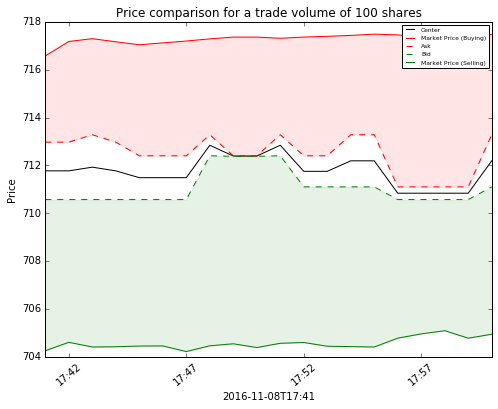

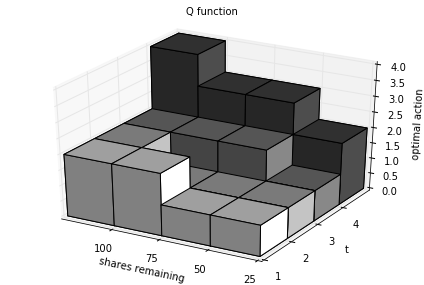

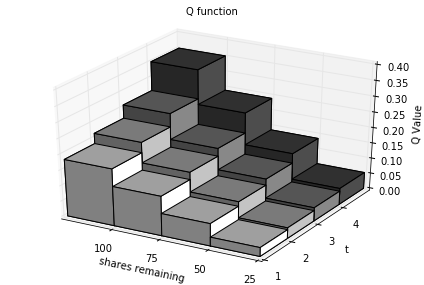

In [8]:
def optimal_strategy(V, H, T, I, L, actions):
    timestamp = datetime.now()

    print("V: {}, H: {}, T: {}, I: {}, L: {}".format(V, H, T, I, L))
    print("actions: {}".format(actions))
    volumes = np.linspace(0, V, num=I+1)[1:][::-1] # skip volumes=0
    volumes_base = V/I
    print("volumes_base: {}".format(volumes_base))
    print("volumes: {}".format(volumes))
    ql = QLearn(actions=actions)

    decisionfrequency = int(H/T)

    for tt in tqdm(range(T, 0, -1)):

        for episode in tqdm(episode_windows[:]):
            # obs_ = episode[decisionfrequency * (tt-1):decisionfrequency * tt]
            # obs = [elem.copy() for elem in obs_]

            center = episode[decisionfrequency * (tt-1)].get_center()
            ask = episode[decisionfrequency * (tt-1)].get_ask()
            initial_center = episode[0].get_center()
            # print("center: {}".format(center))
            
            for vol in volumes:
                for a in actions:
                    state = '[{}, {:2d}]'.format(tt,int(vol))
                    # print("")
                    # print(tt, vol, a, state)
                    if vol == 0:
                        volume_left = 0
                        cost = 0
                    else:
                        ots = OrderbookTradingSimulator(orderbooks=episode[:], volume=vol, tradingperiods=T,
                                                        decisionfrequency=decisionfrequency)
                        ots.t = decisionfrequency * (tt-1)
                        
                        limit = center + a
                        # print(state, actions[a], limit)
                        ots.trade(limit = limit)  # agression_factor=a)
                    
                        volume_left = ots.volume
                        volume_left_rounded = round_custombase(volume_left, base=volumes_base)
            
                        volume_traded = ots.history.volume_traded.values[-1]
                        volume_traded_rounded = round_custombase(volume_traded, base=volumes_base)
                        
                        assert volume_left_rounded + volume_traded_rounded == vol
                        
                        cashflow = ots.history.cashflow[-1]
                        
                        avg = ots.history.avg[-1]
                        cost = volume_traded_rounded * (avg - initial_center) / initial_center

                        # if volume_traded_rounded == 0:
                        #     cost += 1.5
            
                    new_state = '[{}, {:2d}]'.format(tt+1, int(volume_left_rounded))
                    
                    ql.learn(state, a, cost, new_state)
                    # print("  {:1.4f} {:1.4f} {:1.0f} {:1.0f} ".format(cost, (initial_center - avg) / initial_center, volume_traded, volume_traded_rounded))
            ql.plot_Q(V, T, outfile="graphs/Q_function_{}_action".format(tt), outformat='pdf', z_represents='action')
            ql.plot_Q(V, T, outfile="graphs/Q_function_{}_Q".format(tt), outformat='pdf', z_represents='Q')
        ql.save("pickles/Q_function_{}".format(timestamp))
    plot_episode(episode, volume=V)
    return ql

V = 100
ql = optimal_strategy(V=V, H=T*P, T=T, I=4, L=NUM_ACTIONS, actions=actions)
ql.plot_Q(V, T, z_represents='action')
ql.plot_Q(V, T, z_represents='Q')

In [ ]:
V=100
T=4
P=5
ql = QLearn(actions = actions)
# ql = ql.load("pickles/Q_function_e375_T4_P2_V200")
ql = ql.load("pickles/Q_function_e24_T4_P5_V100")
ql.plot_Q(V, T, z_represents='action')
ql.plot_Q(V, T, z_represents='Q')

print(ql)
# ql.plot_Q(V, T, z_represents='both')

# for key in sorted(ql.q)[::-1]:
#     print("")
#     print(key)
#     print(ql.q[key])

In [ ]:
display(episode_windows[0][0].head(5))

In [62]:
def run_Q_fixAdjustment(V, H, T, ql, episode_windows):
    decisionfrequency = int(H/T)
    ql.epsilon = 0.
    for episode in tqdm(episode_windows[0:1]):
        
        print(episode[0].timestamp)
        
        volume = V
        ots = OrderbookTradingSimulator(orderbooks=episode[:4], volume=volume, tradingperiods=T,
                                        decisionfrequency=decisionfrequency)
        
        for tt in tqdm(range(1, T+1, 1)):
            print(ots.orderbooks[ots.t].timestamp)
            lim = 707
            ots.trade(limit = lim)
        
        print("### Fixed limit at: {} ###".format(lim))
        display(ots.history)
        print("cashflow: {}".format(ots.history.cashflow.sum()))
        print("costs: {}".format(ots.history.cost.sum()))
            
    
run_Q_fixAdjustment(V=V, H=T*1, T=T, ql=ql, episode_windows = episode_windows)

  0%|          | 0/4 [00:00<?, ?it/s]

2016-11-08T14:01
2016-11-08T14:01


,Amount,Type
708.400000,0.000110,bid
708.410000,1.744060,bid
708.900000,0.215482,bid
709.264937,NaN,center
709.630000,0.202611,ask
709.700000,0.001040,ask
709.900000,0.443661,ask



 25%|██▌       | 1/4 [00:00<00:00,  6.64it/s]

2016-11-08T14:02


,Amount,Type
708.200000,0.000160,bid
708.400000,0.000110,bid
708.900000,0.205410,bid
709.264937,NaN,center
709.630000,0.198879,ask
709.700000,0.001040,ask
709.900000,0.443661,ask



 50%|█████     | 2/4 [00:00<00:00,  6.91it/s]

2016-11-08T14:03


,Amount,Type
708.200000,0.000160,bid
708.400000,0.000110,bid
708.900000,0.201002,bid
709.264937,NaN,center
709.630000,0.175490,ask
709.700000,0.001040,ask
709.900000,0.443661,ask



 75%|███████▌  | 3/4 [00:00<00:00,  6.87it/s]

2016-11-08T14:04


,Amount,Type
708.200000,0.000160,bid
708.400000,0.000110,bid
708.900000,0.201002,bid
709.264937,NaN,center
709.630000,0.172453,ask
709.700000,0.001040,ask
709.900000,0.443661,ask



100%|██████████| 4/4 [00:00<00:00,  5.61it/s]

### Fixed limit at: 707 ###


,ASK,BID,CENTER,LIMIT,SPREAD,T,VOLUME,avg,cashflow,cost,cost_avg,forced,high,low,volume_traded
2016-11-08T14:01,709.63,708.9,709.264937,707,0.73,1,100,0.0000,0.000000,0.000000,0,False,0.0,inf,0.0
2016-11-08T14:02,709.63,708.9,709.264937,707,0.73,1,100,0.0000,0.000000,0.000000,0,False,0.0,inf,0.0
2016-11-08T14:03,709.63,708.9,709.264937,707,0.73,1,100,0.0000,0.000000,0.000000,0,False,0.0,inf,0.0
2016-11-08T14:04,709.63,708.9,709.264937,707,0.73,1,100,715.3191,-71531.909869,0.853583,0,True,720.0,709.630000,100.0


100%|██████████| 1/1 [00:00<00:00,  1.43it/s]

cashflow: -71531.90986892318
costs: 0.8535826730703926


  0%|          | 0/4 [00:00<?, ?it/s]

V: 100
T: 4
P: 5
decisionfrequency: 5
ots.volume 100
[1, 100] 2.0


,Amount,Type
708.400000,0.000110,bid
708.410000,1.744060,bid
708.900000,0.215482,bid
709.264937,NaN,center
709.630000,0.202611,ask
709.700000,0.001040,ask
709.900000,0.443661,ask



 25%|██▌       | 1/4 [00:00<00:00,  4.64it/s]

ots.volume 96.49588184
[2, 100] 2.0


,Amount,Type
708.800000,1.700000,bid
708.900000,0.199808,bid
709.000000,3.835966,bid
709.494885,NaN,center
709.990000,3.083987,ask
711.280000,0.280000,ask
711.530000,0.000562,ask



 50%|█████     | 2/4 [00:00<00:00,  4.66it/s]

ots.volume 84.27694011
[3, 75] 2.0


,Amount,Type
708.600000,0.000220,bid
708.900000,0.199808,bid
709.100000,5.567642,bid
709.879714,NaN,center
710.660000,0.021883,ask
710.810000,0.030948,ask
712.130000,0.005635,ask



 75%|███████▌  | 3/4 [00:00<00:00,  4.79it/s]

ots.volume 82.69235998
[4, 75] 3.0


,Amount,Type
709.000000,2.300000e-04,bid
709.400000,1.332268e-15,bid
710.070000,9.373170e+00,bid
711.349232,NaN,center
712.630000,6.000000e-02,ask
712.700000,8.493494e-01,ask
712.830000,1.700000e+00,ask



100%|██████████| 4/4 [00:00<00:00,  4.64it/s]

### Learned strategy ###


,ASK,BID,CENTER,LIMIT,SPREAD,T,VOLUME,avg,cashflow,cost,cost_avg,forced,high,low,volume_traded
2016-11-08T14:01,709.63,708.90,709.264937,711.264937,0.73,5,100.000000,710.38351,-2489.267753,0.005526,0,False,711.26,709.63,3.504118
2016-11-08T14:06,709.99,709.00,709.494885,712.089335,0.99,5,96.495882,710.95540,-8687.122573,0.029123,0,False,712.07,709.50,12.218942
2016-11-08T14:11,710.66,709.10,709.879714,712.563851,1.56,5,84.276940,711.86804,-1128.011944,0.005816,0,False,712.51,710.00,1.584580
2016-11-08T14:16,712.63,710.07,711.349232,714.349146,2.56,5,82.692360,715.38405,-59156.795275,0.713420,0,True,717.30,710.14,82.692360


cashflow: -71461.19754504661
costs: 0.7538846685988355

### Fixed limit at: 713.63 (ASK+4) ###


,Amount,Type
708.400000,0.000110,bid
708.410000,1.744060,bid
708.900000,0.215482,bid
709.264937,NaN,center
709.630000,0.202611,ask
709.700000,0.001040,ask
709.900000,0.443661,ask


,Amount,Type
708.800000,1.700000,bid
708.900000,0.199808,bid
709.000000,3.835966,bid
709.494885,NaN,center
709.990000,3.083987,ask
712.450000,0.805038,ask
713.670000,0.106125,ask


,Amount,Type
708.600000,0.000220,bid
708.900000,0.199808,bid
709.100000,5.567642,bid
709.879714,NaN,center
710.660000,0.021883,ask
710.810000,0.030948,ask
713.170000,0.106125,ask


,Amount,Type
709.000000,2.300000e-04,bid
709.400000,1.332268e-15,bid
710.070000,9.373170e+00,bid
711.349232,NaN,center
712.630000,6.000000e-02,ask
713.510000,1.061247e-01,ask
713.700000,4.109500e-04,ask


cashflow: -71434.69307754
costs: 0.7165156706570683

### Fixed limit at: 712.13 (ASK+2.5) ###


,Amount,Type
708.400000,0.000110,bid
708.410000,1.744060,bid
708.900000,0.215482,bid
709.264937,NaN,center
709.630000,0.202611,ask
709.700000,0.001040,ask
709.900000,0.443661,ask


,Amount,Type
708.800000,1.700000,bid
708.900000,0.199808,bid
709.000000,3.835966,bid
709.494885,NaN,center
709.990000,3.083987,ask
712.300000,0.005863,ask
712.310000,0.099999,ask


,Amount,Type
708.600000,0.000220,bid
708.900000,0.199808,bid
709.100000,5.567642,bid
709.879714,NaN,center
710.660000,0.021883,ask
710.810000,0.030948,ask
712.300000,0.005863,ask


,Amount,Type
709.000000,2.300000e-04,bid
709.400000,1.332268e-15,bid
710.070000,9.373170e+00,bid
711.184417,NaN,center
712.300000,5.862590e-03,ask
712.310000,9.999937e-02,ask
712.400000,3.600000e-04,ask


cashflow: -71456.82326243228
costs: 0.7477166375452903

### Fixed limit at: 712.63 (ASK+3) ###


,Amount,Type
708.400000,0.000110,bid
708.410000,1.744060,bid
708.900000,0.215482,bid
709.264937,NaN,center
709.630000,0.202611,ask
709.700000,0.001040,ask
709.900000,0.443661,ask


,Amount,Type
708.800000,1.700000,bid
708.900000,0.199808,bid
709.000000,3.835966,bid
709.494885,NaN,center
709.990000,3.083987,ask
712.450000,0.805038,ask
712.700000,0.849349,ask


,Amount,Type
708.600000,0.000220,bid
708.900000,0.199808,bid
709.100000,5.567642,bid
709.879714,NaN,center
710.660000,0.021883,ask
710.810000,0.030948,ask
712.700000,0.849349,ask


,Amount,Type
709.000000,2.300000e-04,bid
709.400000,1.332268e-15,bid
710.070000,9.373170e+00,bid
711.349232,NaN,center
712.630000,6.000000e-02,ask
712.700000,8.493494e-01,ask
712.830000,1.700000e+00,ask


cashflow: -71443.45729956219
costs: 0.7288723193065496

### Trade at last t ###


,Amount,Type
708.400000,0.000110,bid
708.410000,1.744060,bid
708.900000,0.215482,bid
709.264937,NaN,center
709.630000,0.202611,ask
709.700000,0.001040,ask
709.900000,0.443661,ask


,Amount,Type
708.800000,1.700000,bid
708.900000,0.199808,bid
709.000000,3.835966,bid
709.314953,NaN,center
709.630000,0.008150,ask
709.700000,0.001040,ask
709.900000,0.000800,ask


,Amount,Type
708.600000,2.200000e-04,bid
708.900000,1.998078e-01,bid
709.100000,5.567642e+00,bid
709.364967,NaN,center
709.630000,1.387779e-17,ask
709.900000,2.287667e-17,ask
709.990000,7.285839e-17,ask


,Amount,Type
709.000000,2.300000e-04,bid
709.400000,1.332268e-15,bid
710.070000,9.373170e+00,bid
709.849977,NaN,center
709.630000,1.387779e-17,ask
709.900000,2.287667e-17,ask
709.990000,7.285839e-17,ask


,ASK,BID,CENTER,LIMIT,SPREAD,T,VOLUME,avg,cashflow,cost,cost_avg,forced,high,low,volume_traded
2016-11-08T14:01,709.63,708.90,709.264937,1,0.73,5,100,0.000,0.000000,0.000000,0,False,0.00,inf,0.0
2016-11-08T14:06,709.63,709.00,709.314953,1,0.63,5,100,0.000,0.000000,0.000000,0,False,0.00,inf,0.0
2016-11-08T14:11,709.63,709.10,709.364967,1,0.53,5,100,0.000,0.000000,0.000000,0,False,0.00,inf,0.0
2016-11-08T14:16,709.63,710.07,709.849977,1,-0.44,5,100,716.147,-71614.699884,0.970309,0,True,720.12,709.630000,100.0


cashflow: -71614.69988391326
costs: 0.9703091537348051

### Market Order: No limit ###


,Amount,Type
708.400000,0.000110,bid
708.410000,1.744060,bid
708.900000,0.215482,bid
709.264937,NaN,center
709.630000,0.202611,ask
709.700000,0.001040,ask
709.900000,0.443661,ask


,ASK,BID,CENTER,LIMIT,SPREAD,T,VOLUME,avg,cashflow,cost,cost_avg,forced,high,low,volume_traded
2016-11-08T14:01,709.63,708.9,709.264937,None,0.73,5,100,715.44508,-71544.508496,0.871345,0,False,720.0,709.63,100.0


  0%|          | 0/4 [00:00<?, ?it/s]

cashflow: -71544.50849639623
costs: 0.8713447240839117

ots.volume 100
[1, 100] 2.0


,Amount,Type
709.300000,0.000180,bid
709.400000,0.000110,bid
710.070000,4.905224,bid
710.104999,NaN,center
710.140000,0.000012,ask
711.490000,0.001012,ask
712.830000,2.877296,ask



 25%|██▌       | 1/4 [00:00<00:00,  5.00it/s]

ots.volume 98.26064166
[2, 100] 2.0


,Amount,Type
709.700000,0.000180,bid
710.220000,0.060000,bid
711.000000,6.491557,bid
711.749737,NaN,center
712.500000,0.731666,ask
712.830000,1.700000,ask
713.000000,0.686808,ask



 50%|█████     | 2/4 [00:00<00:00,  5.00it/s]

ots.volume 89.0918219
[3, 100] 2.0


,Amount,Type
710.220000,2.775558e-16,bid
710.800000,1.100000e-04,bid
711.000000,6.433841e+00,bid
712.194332,NaN,center
713.390000,2.215033e-02,ask
713.570000,1.607529e+00,ask
713.600000,1.600000e-04,ask



 75%|███████▌  | 3/4 [00:00<00:00,  4.64it/s]

ots.volume 82.2226964
[4, 75] 3.0


,Amount,Type
710.800000,0.000110,bid
710.900000,0.000110,bid
711.000000,4.830122,bid
712.648727,NaN,center
714.300000,0.106125,ask
714.310000,1.432997,ask
714.350000,0.297009,ask



100%|██████████| 4/4 [00:00<00:00,  4.34it/s]

### Learned strategy ###


,ASK,BID,CENTER,LIMIT,SPREAD,T,VOLUME,avg,cashflow,cost,cost_avg,forced,high,low,volume_traded
2016-11-08T14:21,710.14,710.07,710.104999,712.104999,0.07,5,100.000000,712.07706,-1238.557170,0.004830,0,False,712.10,710.14,1.739358
2016-11-08T14:26,712.50,711.00,711.749737,713.334417,1.50,5,98.260642,712.80801,-6535.608133,0.034901,0,False,713.25,712.44,9.168820
2016-11-08T14:31,713.39,711.00,712.194332,714.284227,2.39,5,89.091822,713.21677,-4899.175476,0.030101,0,False,714.17,712.00,6.869126
2016-11-08T14:36,714.30,711.00,712.648727,715.653719,3.30,5,82.222696,715.91748,-58864.665355,0.673024,0,True,718.98,713.22,82.222696


cashflow: -71538.00613346799
costs: 0.7428570497308258

### Fixed limit at: 714.14 (ASK+4) ###


,Amount,Type
709.300000,0.000180,bid
709.400000,0.000110,bid
710.070000,4.905224,bid
710.104999,NaN,center
710.140000,0.000012,ask
711.490000,0.001012,ask
712.830000,2.877296,ask


,Amount,Type
709.700000,0.000180,bid
710.220000,0.060000,bid
711.000000,6.491557,bid
712.583825,NaN,center
714.170000,0.061046,ask
714.310000,1.432997,ask
714.350000,0.297009,ask


,Amount,Type
710.220000,2.775558e-16,bid
710.800000,1.100000e-04,bid
711.000000,6.433841e+00,bid
712.194332,NaN,center
713.390000,2.215033e-02,ask
713.690000,3.132529e-02,ask
714.150000,2.700000e-01,ask


,Amount,Type
710.80000,0.000110,bid
710.90000,0.000110,bid
711.00000,4.830122,bid
712.57384,NaN,center
714.15000,0.270000,ask
714.17000,0.061046,ask
714.30000,0.106125,ask


cashflow: -71508.12120982159
costs: 0.7007717952289351

### Fixed limit at: 712.64 (ASK+2.5) ###


,Amount,Type
709.300000,0.000180,bid
709.400000,0.000110,bid
710.070000,4.905224,bid
710.104999,NaN,center
710.140000,0.000012,ask
711.490000,0.001012,ask
712.830000,2.877296,ask


,Amount,Type
709.700000,0.000180,bid
710.220000,0.060000,bid
711.000000,6.491557,bid
711.914608,NaN,center
712.830000,1.700000,ask
713.000000,0.686808,ask
713.200000,2.400000,ask


,Amount,Type
710.220000,2.775558e-16,bid
710.800000,1.100000e-04,bid
711.000000,6.433841e+00,bid
711.999532,NaN,center
713.000000,6.868083e-01,ask
713.200000,2.400000e+00,ask
713.250000,4.621652e-01,ask


,Amount,Type
710.800000,0.000110,bid
710.900000,0.000110,bid
711.000000,4.830122,bid
711.999532,NaN,center
713.000000,0.039788,ask
713.190000,0.462200,ask
713.200000,2.400000,ask


cashflow: -71569.7606528686
costs: 0.7875749985722834

### Fixed limit at: 713.14 (ASK+3) ###


,Amount,Type
709.300000,0.000180,bid
709.400000,0.000110,bid
710.070000,4.905224,bid
710.104999,NaN,center
710.140000,0.000012,ask
711.490000,0.001012,ask
712.830000,2.877296,ask


,Amount,Type
709.700000,0.000180,bid
710.220000,0.060000,bid
711.000000,6.491557,bid
712.099434,NaN,center
713.200000,2.400000,ask
713.250000,0.462165,ask
713.570000,1.607529,ask


,Amount,Type
710.220000,2.775558e-16,bid
710.800000,1.100000e-04,bid
711.000000,6.433841e+00,bid
712.099434,NaN,center
713.200000,2.400000e+00,ask
713.250000,4.621652e-01,ask
713.390000,2.215033e-02,ask


,Amount,Type
710.800000,0.000110,bid
710.900000,0.000110,bid
711.000000,4.830122,bid
712.094439,NaN,center
713.190000,0.462200,ask
713.200000,2.400000,ask
713.570000,1.607529,ask


cashflow: -71540.7731543211
costs: 0.7467529008764506

### Trade at last t ###


,Amount,Type
709.300000,0.000180,bid
709.400000,0.000110,bid
710.070000,4.905224,bid
710.104999,NaN,center
710.140000,0.000012,ask
711.490000,0.001012,ask
712.830000,2.877296,ask


,Amount,Type
709.700000,0.000180,bid
710.220000,0.060000,bid
711.000000,6.491557,bid
711.749737,NaN,center
712.500000,0.731666,ask
712.830000,1.700000,ask
713.000000,0.686808,ask


,Amount,Type
710.220000,2.775558e-16,bid
710.800000,1.100000e-04,bid
711.000000,6.433841e+00,bid
711.749737,NaN,center
712.500000,1.110223e-16,ask
713.000000,6.868083e-01,ask
713.200000,2.400000e+00,ask


,Amount,Type
710.800000,0.000110,bid
710.900000,0.000110,bid
711.000000,4.830122,bid
711.749737,NaN,center
712.500000,2.345403,ask
713.000000,0.039788,ask
713.190000,0.462200,ask


,ASK,BID,CENTER,LIMIT,SPREAD,T,VOLUME,avg,cashflow,cost,cost_avg,forced,high,low,volume_traded
2016-11-08T14:21,710.14,710.07,710.104999,1,0.07,5,100,0.00000,0.000000,0.000000,0,False,0.00,inf,0.0
2016-11-08T14:26,712.50,711.00,711.749737,1,1.50,5,100,0.00000,0.000000,0.000000,0,False,0.00,inf,0.0
2016-11-08T14:31,712.50,711.00,711.749737,1,1.50,5,100,0.00000,0.000000,0.000000,0,False,0.00,inf,0.0
2016-11-08T14:36,712.50,711.00,711.749737,1,1.50,5,100,716.60139,-71660.139237,0.914849,0,True,720.13,713.530000,100.0


cashflow: -71660.13923703141
costs: 0.9148492939242323

### Market Order: No limit ###


,Amount,Type
709.300000,0.000180,bid
709.400000,0.000110,bid
710.070000,4.905224,bid
710.104999,NaN,center
710.140000,0.000012,ask
711.490000,0.001012,ask
712.830000,2.877296,ask


,ASK,BID,CENTER,LIMIT,SPREAD,T,VOLUME,avg,cashflow,cost,cost_avg,forced,high,low,volume_traded
2016-11-08T14:21,710.14,710.07,710.104999,None,0.07,5,100,716.74507,-71674.507033,0.935083,0,False,720.12,710.14,100.0


  0%|          | 0/4 [00:00<?, ?it/s]

cashflow: -71674.50703286828
costs: 0.9350829213618693

ots.volume 100
[1, 100] 2.0


,Amount,Type
710.900000,0.000110,bid
711.000000,6.441572,bid
712.500000,0.005021,bid
713.014876,NaN,center
713.530000,2.216500,ask
713.600000,0.000160,ask
713.700000,0.000411,ask



 25%|██▌       | 1/4 [00:00<00:00,  5.56it/s]

ots.volume 52.45892147
[2, 50] 1.0


,Amount,Type
712.600000,1.590000,bid
712.740000,0.017027,bid
714.000000,2.332762,bid
714.454903,NaN,center
714.910000,0.060000,ask
715.030000,0.031488,ask
715.160000,0.879410,ask



 50%|█████     | 2/4 [00:00<00:00,  5.41it/s]

ots.volume 46.87482736
[3, 50] 2.0


,Amount,Type
712.000000,0.000110,bid
712.500000,0.005021,bid
712.740000,3.153223,bid
713.284861,NaN,center
713.830000,0.668702,ask
714.740000,1.826000,ask
715.570000,1.571028,ask



 75%|███████▌  | 3/4 [00:00<00:00,  5.47it/s]

ots.volume 37.3694218
[4, 25] 2.0


,Amount,Type
712.000000,0.000110,bid
712.500000,0.005021,bid
712.740000,0.017027,bid
713.094941,NaN,center
713.450000,1.528606,ask
713.600000,0.002728,ask
715.000000,1.301317,ask



100%|██████████| 4/4 [00:00<00:00,  5.32it/s]

### Learned strategy ###


,ASK,BID,CENTER,LIMIT,SPREAD,T,VOLUME,avg,cashflow,cost,cost_avg,forced,high,low,volume_traded
2016-11-08T14:41,713.53,712.50,713.014876,715.014876,1.03,5,100.000000,714.82477,-33983.540361,0.120677,0,False,715.00,713.53,47.541079
2016-11-08T14:46,714.91,714.00,714.454903,715.514876,0.91,5,52.458921,714.47675,-3989.705401,0.011449,0,False,715.16,714.00,5.584094
2016-11-08T14:51,713.83,712.74,713.284861,716.154065,1.09,5,46.874827,714.58303,-6792.401464,0.020906,0,False,716.08,713.00,9.505406
2016-11-08T14:56,713.45,712.74,713.094941,716.643783,0.71,5,37.369422,716.78829,-26785.963892,0.197766,0,True,718.61,712.74,37.369422


cashflow: -71551.6111174472
costs: 0.3507974399145921

### Fixed limit at: 717.53 (ASK+4) ###


,Amount,Type
710.900000,0.000110,bid
711.000000,6.441572,bid
712.500000,0.005021,bid
713.014876,NaN,center
713.530000,2.216500,ask
713.600000,0.000160,ask
713.700000,0.000411,ask


,Amount,Type
712.600000,1.590000,bid
712.740000,0.017027,bid
714.000000,2.332762,bid
714.454903,NaN,center
714.910000,0.060000,ask
715.160000,0.879410,ask
715.570000,3.149028,ask


cashflow: -71573.074108796
costs: 0.3808990494927793

### Fixed limit at: 716.03 (ASK+2.5) ###


,Amount,Type
710.900000,0.000110,bid
711.000000,6.441572,bid
712.500000,0.005021,bid
713.014876,NaN,center
713.530000,2.216500,ask
713.600000,0.000160,ask
713.700000,0.000411,ask


,Amount,Type
712.600000,1.590000,bid
712.740000,0.017027,bid
714.000000,2.332762,bid
714.454903,NaN,center
714.910000,0.060000,ask
715.160000,0.879410,ask
715.570000,3.149028,ask


,Amount,Type
712.000000,0.000110,bid
712.500000,0.005021,bid
712.740000,3.153223,bid
713.284861,NaN,center
713.830000,0.668702,ask
714.740000,1.826000,ask
716.040000,1.149538,ask


,Amount,Type
712.000000,0.000110,bid
712.500000,0.005021,bid
712.740000,0.017027,bid
713.094941,NaN,center
713.450000,1.528606,ask
713.600000,0.002728,ask
715.000000,1.301317,ask


cashflow: -71535.34814623892
costs: 0.3279882107109007

### Fixed limit at: 716.53 (ASK+3) ###


,Amount,Type
710.900000,0.000110,bid
711.000000,6.441572,bid
712.500000,0.005021,bid
713.014876,NaN,center
713.530000,2.216500,ask
713.600000,0.000160,ask
713.700000,0.000411,ask


,Amount,Type
712.600000,1.590000,bid
712.740000,0.017027,bid
714.000000,2.332762,bid
714.454903,NaN,center
714.910000,0.060000,ask
715.160000,0.879410,ask
715.570000,3.149028,ask


,Amount,Type
712.000000,0.000110,bid
712.500000,0.005021,bid
712.740000,3.153223,bid
713.284861,NaN,center
713.830000,0.668702,ask
714.740000,1.826000,ask
716.700000,0.011654,ask


,Amount,Type
712.000000,0.000110,bid
712.500000,0.005021,bid
712.740000,0.017027,bid
713.094941,NaN,center
713.450000,1.528606,ask
713.600000,0.002728,ask
715.000000,1.301317,ask


cashflow: -71533.0981668648
costs: 0.32483297271726363

### Trade at last t ###


,Amount,Type
710.900000,0.000110,bid
711.000000,6.441572,bid
712.500000,0.005021,bid
713.014876,NaN,center
713.530000,2.216500,ask
713.600000,0.000160,ask
713.700000,0.000411,ask


,Amount,Type
712.600000,1.590000,bid
712.740000,0.017027,bid
714.000000,2.332762,bid
714.454903,NaN,center
714.910000,0.060000,ask
715.000000,26.635460,ask
715.030000,0.031488,ask


,Amount,Type
712.000000,0.000110,bid
712.500000,0.005021,bid
712.740000,3.153223,bid
713.284861,NaN,center
713.830000,0.668702,ask
714.000000,1.482647,ask
714.280000,1.454512,ask


,Amount,Type
712.000000,0.000110,bid
712.500000,0.005021,bid
712.740000,0.017027,bid
713.094941,NaN,center
713.450000,1.528606,ask
713.600000,0.002728,ask
713.800000,1.901988,ask


,ASK,BID,CENTER,LIMIT,SPREAD,T,VOLUME,avg,cashflow,cost,cost_avg,forced,high,low,volume_traded
2016-11-08T14:41,713.53,712.50,713.014876,1,1.03,5,100,0.00000,0.000000,0.000000,0,False,0.00,inf,0.0
2016-11-08T14:46,714.91,714.00,714.454903,1,0.91,5,100,0.00000,0.000000,0.000000,0,False,0.00,inf,0.0
2016-11-08T14:51,713.83,712.74,713.284861,1,1.09,5,100,0.00000,0.000000,0.000000,0,False,0.00,inf,0.0
2016-11-08T14:56,713.45,712.74,713.094941,1,0.71,5,100,717.12132,-71712.132396,0.575927,0,True,720.13,712.740000,100.0


cashflow: -71712.13239599168
costs: 0.5759268326956055

### Market Order: No limit ###


,Amount,Type
710.900000,0.000110,bid
711.000000,6.441572,bid
712.500000,0.005021,bid
713.014876,NaN,center
713.530000,2.216500,ask
713.600000,0.000160,ask
713.700000,0.000411,ask


,ASK,BID,CENTER,LIMIT,SPREAD,T,VOLUME,avg,cashflow,cost,cost_avg,forced,high,low,volume_traded
2016-11-08T14:41,713.53,712.5,713.014876,None,1.03,5,100,716.57632,-71657.631833,0.499491,0,False,720.13,713.53,100.0


  0%|          | 0/4 [00:00<?, ?it/s]

cashflow: -71657.6318328469
costs: 0.4994908397958058

ots.volume 100
[1, 100] 2.0


,Amount,Type
711.900000,0.000340,bid
712.000000,0.000110,bid
712.400000,0.000087,bid
712.569986,NaN,center
712.740000,0.413659,ask
713.450000,0.010410,ask
713.800000,1.855988,ask



 25%|██▌       | 1/4 [00:00<00:00,  6.01it/s]

ots.volume 65.78642351
[2, 75] 1.0


,Amount,Type
711.680000,0.004986,bid
712.500000,0.000510,bid
712.800000,0.000390,bid
713.769561,NaN,center
714.740000,1.535410,ask
715.000000,27.936777,ask
715.160000,0.879403,ask



 50%|█████     | 2/4 [00:00<00:00,  5.94it/s]

ots.volume 60.05217326
[3, 50] 2.0


,Amount,Type
711.680000,0.004986,bid
712.500000,0.000510,bid
712.800000,0.000390,bid
713.544741,NaN,center
714.290000,1.517417,ask
715.000000,28.116354,ask
715.160000,0.879403,ask



 75%|███████▌  | 3/4 [00:00<00:00,  5.87it/s]

ots.volume 26.28896888
[4, 25] 2.0


,Amount,Type
711.300000,2.380000e-06,bid
711.680000,1.768800e+00,bid
712.800000,4.347651e-17,bid
713.994333,NaN,center
715.190000,8.793746e-01,ask
716.000000,8.379890e-03,ask
716.040000,2.851538e+00,ask



100%|██████████| 4/4 [00:00<00:00,  5.43it/s]

### Learned strategy ###


,ASK,BID,CENTER,LIMIT,SPREAD,T,VOLUME,avg,cashflow,cost,cost_avg,forced,high,low,volume_traded
2016-11-08T15:01,712.74,712.4,712.569986,714.569986,0.34,5,100.000000,714.00724,-24428.741455,0.069009,0,False,714.39,712.74,34.213576
2016-11-08T15:06,714.74,712.8,713.769561,714.769561,1.94,5,65.786424,714.28812,-4095.906846,0.013826,0,False,714.74,714.00,5.734250
2016-11-08T15:11,714.29,712.8,713.544741,715.899435,1.49,5,60.052173,715.02683,-24141.597020,0.116411,0,False,715.70,714.00,33.763204
2016-11-08T15:16,715.19,712.8,713.994333,716.398806,2.39,5,26.288969,716.49274,-18835.855233,0.144723,0,True,717.24,714.00,26.288969


cashflow: -71502.1005540105
costs: 0.34396880388385676

### Fixed limit at: 716.74 (ASK+4) ###


,Amount,Type
711.900000,0.000340,bid
712.000000,0.000110,bid
712.400000,0.000087,bid
712.569986,NaN,center
712.740000,0.413659,ask
713.450000,0.010410,ask
713.800000,1.855988,ask


,Amount,Type
711.680000,0.004986,bid
712.500000,0.000510,bid
712.800000,0.000390,bid
714.788153,NaN,center
716.780000,0.902557,ask
716.800000,0.004009,ask
716.850000,0.106125,ask


,Amount,Type
711.680000,0.004986,bid
712.500000,0.000510,bid
712.800000,0.000390,bid
713.544741,NaN,center
714.290000,1.517417,ask
715.000000,0.179578,ask
716.780000,0.902557,ask


,Amount,Type
711.300000,2.380000e-06,bid
711.680000,1.768800e+00,bid
712.800000,4.347651e-17,bid
713.994333,NaN,center
715.190000,8.793746e-01,ask
716.780000,9.025573e-01,ask
716.800000,4.008880e-03,ask


cashflow: -71502.0843142155
costs: 0.34394618374897873

### Fixed limit at: 715.24 (ASK+2.5) ###


,Amount,Type
711.900000,0.000340,bid
712.000000,0.000110,bid
712.400000,0.000087,bid
712.569986,NaN,center
712.740000,0.413659,ask
713.450000,0.010410,ask
713.800000,1.855988,ask


,Amount,Type
711.680000,0.004986,bid
712.500000,0.000510,bid
712.800000,0.000390,bid
714.184105,NaN,center
715.570000,1.571028,ask
715.600000,0.000470,ask
715.650000,0.008871,ask


,Amount,Type
711.680000,0.004986,bid
712.500000,0.000510,bid
712.800000,0.000390,bid
713.544741,NaN,center
714.290000,1.517417,ask
715.000000,0.179578,ask
715.570000,1.571028,ask


,Amount,Type
711.300000,2.380000e-06,bid
711.680000,1.768800e+00,bid
712.800000,4.347651e-17,bid
713.994333,NaN,center
715.190000,8.793746e-01,ask
715.560000,1.000000e-03,ask
715.630000,1.570887e+00,ask


cashflow: -71506.76734162061
costs: 0.35051820942924933

### Fixed limit at: 715.74 (ASK+3) ###


,Amount,Type
711.900000,0.000340,bid
712.000000,0.000110,bid
712.400000,0.000087,bid
712.569986,NaN,center
712.740000,0.413659,ask
713.450000,0.010410,ask
713.800000,1.855988,ask


,Amount,Type
711.680000,0.004986,bid
712.500000,0.000510,bid
712.800000,0.000390,bid
714.398806,NaN,center
716.000000,0.008380,ask
716.040000,1.149538,ask
716.050000,0.250000,ask


,Amount,Type
711.680000,0.004986,bid
712.500000,0.000510,bid
712.800000,0.000390,bid
713.544741,NaN,center
714.290000,1.517417,ask
715.000000,0.179578,ask
716.000000,0.008380,ask


,Amount,Type
711.300000,2.380000e-06,bid
711.680000,1.768800e+00,bid
712.800000,4.347651e-17,bid
713.994333,NaN,center
715.190000,8.793746e-01,ask
716.000000,8.379890e-03,ask
716.040000,2.851538e+00,ask


cashflow: -71504.14295401052
costs: 0.3468350574096094

### Trade at last t ###


,Amount,Type
711.900000,0.000340,bid
712.000000,0.000110,bid
712.400000,0.000087,bid
712.569986,NaN,center
712.740000,0.413659,ask
713.450000,0.010410,ask
713.800000,1.855988,ask


,Amount,Type
711.680000,0.004986,bid
712.500000,0.000510,bid
712.800000,0.000390,bid
713.399832,NaN,center
714.000000,21.556472,ask
714.330000,1.503430,ask
714.740000,1.535410,ask


,Amount,Type
711.680000,0.004986,bid
712.500000,0.000510,bid
712.800000,0.000390,bid
713.399832,NaN,center
714.000000,24.096004,ask
714.290000,1.517417,ask
714.740000,1.535410,ask


,Amount,Type
711.300000,2.380000e-06,bid
711.680000,1.768800e+00,bid
712.800000,4.347651e-17,bid
713.399832,NaN,center
714.000000,2.178674e+01,ask
714.730000,6.000000e-02,ask
715.000000,2.811592e+01,ask


,ASK,BID,CENTER,LIMIT,SPREAD,T,VOLUME,avg,cashflow,cost,cost_avg,forced,high,low,volume_traded
2016-11-08T15:01,712.74,712.4,712.569986,1,0.34,5,100,0.00000,0.000000,0.000000,0,False,0.00,inf,0.0
2016-11-08T15:06,714.00,712.8,713.399832,1,1.20,5,100,0.00000,0.000000,0.000000,0,False,0.00,inf,0.0
2016-11-08T15:11,714.00,712.8,713.399832,1,1.20,5,100,0.00000,0.000000,0.000000,0,False,0.00,inf,0.0
2016-11-08T15:16,714.00,712.8,713.399832,1,1.20,5,100,716.58071,-71658.071282,0.562853,0,True,720.13,714.000000,100.0


cashflow: -71658.07128159472
costs: 0.5628532770501221

### Market Order: No limit ###


,Amount,Type
711.900000,0.000340,bid
712.000000,0.000110,bid
712.400000,0.000087,bid
712.569986,NaN,center
712.740000,0.413659,ask
713.450000,0.010410,ask
713.800000,1.855988,ask


,ASK,BID,CENTER,LIMIT,SPREAD,T,VOLUME,avg,cashflow,cost,cost_avg,forced,high,low,volume_traded
2016-11-08T15:01,712.74,712.4,712.569986,None,0.34,5,100,717.12467,-71712.46727,0.639191,0,False,720.13,712.74,100.0


  0%|          | 0/4 [00:00<?, ?it/s]

cashflow: -71712.467270289
costs: 0.6391910418060176

ots.volume 100
[1, 100] 2.0


,Amount,Type
711.240000,1.626000,bid
711.300000,0.000002,bid
711.680000,0.190940,bid
712.839371,NaN,center
714.000000,14.856232,ask
715.000000,28.115924,ask
715.190000,0.879375,ask



 25%|██▌       | 1/4 [00:00<00:00,  6.36it/s]

ots.volume 74.33230788
[2, 75] 1.0


,Amount,Type
710.780000,1.840200,bid
711.200000,1.722155,bid
711.680000,0.006679,bid
713.044129,NaN,center
714.410000,0.260000,ask
714.980000,0.040000,ask
715.000000,27.936347,ask



 50%|█████     | 2/4 [00:00<00:00,  6.41it/s]

ots.volume 74.22097044
[3, 75] 2.0


,Amount,Type
714.000000,2.676087,bid
714.360000,1.900000,bid
714.780000,1.883337,bid
714.889994,NaN,center
715.000000,27.936347,ask
715.100000,0.060000,ask
715.560000,0.001000,ask



 75%|███████▌  | 3/4 [00:00<00:00,  6.21it/s]

ots.volume 45.96202645
[4, 50] 3.0


,Amount,Type
714.360000,1.900000,bid
714.750000,5.771810,bid
715.210000,1.332946,bid
715.599929,NaN,center
715.990000,0.031517,ask
716.000000,16.014436,ask
716.010000,0.031519,ask



100%|██████████| 4/4 [00:00<00:00,  5.79it/s]

### Learned strategy ###


,ASK,BID,CENTER,LIMIT,SPREAD,T,VOLUME,avg,cashflow,cost,cost_avg,forced,high,low,volume_traded
2016-11-08T15:21,714.00,711.68,712.839371,714.839371,2.32,5,100.000000,714.10061,-18329.314538,0.045414,0,False,714.83,714.00,25.667692
2016-11-08T15:26,714.41,711.68,713.044129,714.338712,2.73,5,74.332308,714.00000,-79.494932,0.000181,0,False,714.00,714.00,0.111337
2016-11-08T15:31,715.00,714.78,714.889994,715.984916,0.22,5,74.220970,715.00532,-20205.295396,0.085864,0,False,715.93,715.00,28.258944
2016-11-08T15:36,715.99,715.21,715.599929,718.374818,0.78,5,45.962026,718.34495,-33016.589411,0.354985,0,True,720.13,715.99,45.962026


cashflow: -71630.6942776587
costs: 0.48644526547007316

### Fixed limit at: 718.0 (ASK+4) ###


,Amount,Type
711.240000,1.626000,bid
711.300000,0.000002,bid
711.680000,0.190940,bid
712.839371,NaN,center
714.000000,14.856232,ask
715.000000,28.115924,ask
715.190000,0.879375,ask


,Amount,Type
710.780000,1.840200,bid
711.200000,1.722155,bid
711.680000,0.006679,bid
713.044129,NaN,center
714.410000,0.260000,ask
714.980000,0.040000,ask
715.190000,1.585000,ask


cashflow: -71557.06424585733
costs: 0.3831532689639255

### Fixed limit at: 716.5 (ASK+2.5) ###


,Amount,Type
711.240000,1.626000,bid
711.300000,0.000002,bid
711.680000,0.190940,bid
712.839371,NaN,center
714.000000,14.856232,ask
715.000000,28.115924,ask
715.190000,0.879375,ask


,Amount,Type
710.780000,1.840200,bid
711.200000,1.722155,bid
711.680000,0.006679,bid
713.044129,NaN,center
714.410000,0.260000,ask
714.980000,0.040000,ask
715.190000,1.585000,ask


,Amount,Type
714.000000,2.676087,bid
714.360000,1.900000,bid
714.780000,1.883337,bid
714.939988,NaN,center
715.100000,0.060000,ask
716.000000,14.065152,ask
716.350000,0.260000,ask


,Amount,Type
714.360000,1.900000,bid
714.750000,5.771810,bid
715.210000,1.332946,bid
715.599929,NaN,center
715.990000,0.031517,ask
716.800000,0.004009,ask
717.020000,0.011654,ask


cashflow: -71553.4036375558
costs: 0.3780180927233828

### Fixed limit at: 717.0 (ASK+3) ###


,Amount,Type
711.240000,1.626000,bid
711.300000,0.000002,bid
711.680000,0.190940,bid
712.839371,NaN,center
714.000000,14.856232,ask
715.000000,28.115924,ask
715.190000,0.879375,ask


,Amount,Type
710.780000,1.840200,bid
711.200000,1.722155,bid
711.680000,0.006679,bid
713.044129,NaN,center
714.410000,0.260000,ask
714.980000,0.040000,ask
715.190000,1.585000,ask


,Amount,Type
714.000000,2.676087,bid
714.360000,1.900000,bid
714.780000,1.883337,bid
714.939988,NaN,center
715.100000,0.060000,ask
716.000000,14.065152,ask
716.350000,0.260000,ask


,Amount,Type
714.360000,1.900000,bid
714.750000,5.771810,bid
715.210000,1.332946,bid
715.599929,NaN,center
715.990000,0.031517,ask
717.020000,0.011654,ask
717.100000,0.084623,ask


cashflow: -71550.49740304981
costs: 0.37394127933303456

### Trade at last t ###


,Amount,Type
711.240000,1.626000,bid
711.300000,0.000002,bid
711.680000,0.190940,bid
712.839371,NaN,center
714.000000,14.856232,ask
715.000000,28.115924,ask
715.190000,0.879375,ask


,Amount,Type
710.780000,1.840200,bid
711.200000,1.722155,bid
711.680000,0.006679,bid
712.839371,NaN,center
714.000000,22.533384,ask
714.410000,0.260000,ask
714.820000,1.565082,ask


,Amount,Type
714.000000,2.676087,bid
714.360000,1.900000,bid
714.780000,1.883337,bid
714.889994,NaN,center
715.000000,27.936347,ask
715.100000,0.060000,ask
715.560000,0.001000,ask


,Amount,Type
714.360000,1.900000e+00,bid
714.750000,5.771810e+00,bid
715.210000,1.332946e+00,bid
715.384986,NaN,center
715.560000,8.673617e-19,ask
715.650000,3.057119e-02,ask
715.670000,1.640000e-06,ask


,ASK,BID,CENTER,LIMIT,SPREAD,T,VOLUME,avg,cashflow,cost,cost_avg,forced,high,low,volume_traded
2016-11-08T15:21,714.00,711.68,712.839371,1,2.32,5,100,0.00000,0.000000,0.000000,0,False,0.00,inf,0.0
2016-11-08T15:26,714.00,711.68,712.839371,1,2.32,5,100,0.00000,0.000000,0.000000,0,False,0.00,inf,0.0
2016-11-08T15:31,715.00,714.78,714.889994,1,0.22,5,100,0.00000,0.000000,0.000000,0,False,0.00,inf,0.0
2016-11-08T15:36,715.56,715.21,715.384986,1,0.35,5,100,720.39964,-72039.964381,1.060585,0,True,724.54,715.560000,100.0


cashflow: -72039.96438147902
costs: 1.060585249702907

### Market Order: No limit ###


,Amount,Type
711.240000,1.626000,bid
711.300000,0.000002,bid
711.680000,0.190940,bid
712.839371,NaN,center
714.000000,14.856232,ask
715.000000,28.115924,ask
715.190000,0.879375,ask


,ASK,BID,CENTER,LIMIT,SPREAD,T,VOLUME,avg,cashflow,cost,cost_avg,forced,high,low,volume_traded
2016-11-08T15:21,714.0,711.68,712.839371,None,2.32,5,100,716.58968,-71658.968151,0.526109,0,False,720.13,714.0,100.0


  0%|          | 0/4 [00:00<?, ?it/s]

cashflow: -71658.96815120713
costs: 0.5261085981349644

ots.volume 100
[1, 100] 2.0


,Amount,Type
714.110000,1.900000,bid
714.150000,0.256636,bid
714.880000,6.936721,bid
715.439854,NaN,center
716.000000,14.675763,ask
716.010000,0.031519,ask
716.080000,0.031876,ask



 25%|██▌       | 1/4 [00:00<00:00,  5.63it/s]

ots.volume 65.0391744
[2, 75] 1.0


,Amount,Type
713.900000,0.002480,bid
714.000000,6.982433,bid
714.700000,0.001200,bid
715.349803,NaN,center
716.000000,0.237464,ask
717.450000,0.011654,ask
717.480000,0.000252,ask



 50%|█████     | 2/4 [00:00<00:00,  5.67it/s]

ots.volume 64.80171035
[3, 75] 2.0


,Amount,Type
713.840000,1.917208,bid
713.900000,0.002480,bid
714.000000,6.928107,bid
715.723614,NaN,center
717.450000,0.011654,ask
717.480000,0.000252,ask
717.590000,0.011654,ask



 75%|███████▌  | 3/4 [00:00<00:00,  5.83it/s]

ots.volume 58.49198638
[4, 50] 3.0


,Amount,Type
713.650000,0.003940,bid
713.900000,0.002480,bid
714.000000,6.751552,bid
714.499883,NaN,center
715.000000,0.095521,ask
717.310000,2.100000,ask
717.740000,2.251195,ask



100%|██████████| 4/4 [00:00<00:00,  5.57it/s]


### Learned strategy ###


,ASK,BID,CENTER,LIMIT,SPREAD,T,VOLUME,avg,cashflow,cost,cost_avg,forced,high,low,volume_traded
2016-11-08T15:41,716.00,714.88,715.439854,717.439854,1.12,5,100.000000,715.74257,-25022.951185,0.014793,0,False,717.35,715.0,34.960826
2016-11-08T15:46,716.00,714.70,715.349803,717.074120,1.30,5,65.039174,716.00000,-170.024260,0.000186,0,False,716.00,716.0,0.237464
2016-11-08T15:51,717.45,714.00,715.723614,717.723614,3.45,5,64.801710,717.13620,-4524.931466,0.014961,0,False,717.70,715.0,6.309724
2016-11-08T15:56,715.00,714.00,714.499883,718.868372,1.00,5,58.491986,718.97471,-42054.259198,0.288998,0,True,720.13,714.0,58.491986


cashflow: -71772.1661099644
costs: 0.31893729382381125

### Fixed limit at: 720.0 (ASK+4) ###


,Amount,Type
714.110000,1.900000,bid
714.150000,0.256636,bid
714.880000,6.936721,bid
715.439854,NaN,center
716.000000,14.675763,ask
716.010000,0.031519,ask
716.080000,0.031876,ask


,Amount,Type
713.900000,0.002480,bid
714.000000,6.982433,bid
714.700000,0.001200,bid
715.349803,NaN,center
716.000000,0.237464,ask
719.900000,0.790000,ask
720.070000,1.025513,ask


,Amount,Type
713.840000,1.917208,bid
713.900000,0.002480,bid
714.000000,6.928107,bid
716.132878,NaN,center
718.270000,1.452000,ask
720.070000,1.025513,ask
720.120000,4.950000,ask


,Amount,Type
713.650000,0.003940,bid
713.900000,0.002480,bid
714.000000,6.751552,bid
714.499883,NaN,center
715.000000,0.095521,ask
717.310000,2.100000,ask
720.070000,1.025513,ask


cashflow: -71748.6485926004
costs: 0.286065690637477

### Fixed limit at: 718.5 (ASK+2.5) ###


,Amount,Type
714.110000,1.900000,bid
714.150000,0.256636,bid
714.880000,6.936721,bid
715.439854,NaN,center
716.000000,14.675763,ask
716.010000,0.031519,ask
716.080000,0.031876,ask


,Amount,Type
713.900000,0.002480,bid
714.000000,6.982433,bid
714.700000,0.001200,bid
715.349803,NaN,center
716.000000,0.237464,ask
718.750000,1.806286,ask
718.810000,0.011654,ask


,Amount,Type
713.840000,1.917208,bid
713.900000,0.002480,bid
714.000000,6.928107,bid
716.132878,NaN,center
718.270000,1.452000,ask
718.750000,1.806286,ask
718.810000,0.011654,ask


,Amount,Type
713.650000,0.003940,bid
713.900000,0.002480,bid
714.000000,6.751552,bid
714.499883,NaN,center
715.000000,0.095521,ask
717.310000,2.100000,ask
718.750000,1.806286,ask


cashflow: -71750.72060350039
costs: 0.2889629514850382

### Fixed limit at: 719.0 (ASK+3) ###


,Amount,Type
714.110000,1.900000,bid
714.150000,0.256636,bid
714.880000,6.936721,bid
715.439854,NaN,center
716.000000,14.675763,ask
716.010000,0.031519,ask
716.080000,0.031876,ask


,Amount,Type
713.900000,0.002480,bid
714.000000,6.982433,bid
714.700000,0.001200,bid
715.349803,NaN,center
716.000000,0.237464,ask
719.200000,0.000590,ask
719.290000,2.300000,ask


,Amount,Type
713.840000,1.917208,bid
713.900000,0.002480,bid
714.000000,6.928107,bid
716.132878,NaN,center
718.270000,1.452000,ask
719.200000,0.000590,ask
719.290000,2.300000,ask


,Amount,Type
713.650000,0.003940,bid
713.900000,0.002480,bid
714.000000,6.751552,bid
714.499883,NaN,center
715.000000,0.095521,ask
717.310000,2.100000,ask
719.200000,0.000590,ask


cashflow: -71750.72060350039
costs: 0.2889625497475497

### Trade at last t ###


,Amount,Type
714.110000,1.900000,bid
714.150000,0.256636,bid
714.880000,6.936721,bid
715.439854,NaN,center
716.000000,14.675763,ask
716.010000,0.031519,ask
716.080000,0.031876,ask


,Amount,Type
713.90000,0.002480,bid
714.00000,6.982433,bid
714.70000,0.001200,bid
714.84999,NaN,center
715.00000,7.599806,ask
716.00000,0.558872,ask
716.08000,0.031876,ask


,Amount,Type
713.840000,1.917208,bid
713.900000,0.002480,bid
714.000000,6.928107,bid
714.499883,NaN,center
715.000000,6.112576,ask
716.000000,0.558872,ask
716.080000,0.031876,ask


,Amount,Type
713.650000,0.003940,bid
713.900000,0.002480,bid
714.000000,6.751552,bid
714.499883,NaN,center
715.000000,4.455489,ask
716.000000,0.558872,ask
716.080000,0.031876,ask


,ASK,BID,CENTER,LIMIT,SPREAD,T,VOLUME,avg,cashflow,cost,cost_avg,forced,high,low,volume_traded
2016-11-08T15:41,716.0,714.88,715.439854,1,1.12,5,100,0.00000,0.000000,0.000000,0,False,0.0,inf,0.0
2016-11-08T15:46,715.0,714.70,714.849990,1,0.30,5,100,0.00000,0.000000,0.000000,0,False,0.0,inf,0.0
2016-11-08T15:51,715.0,714.00,714.499883,1,1.00,5,100,0.00000,0.000000,0.000000,0,False,0.0,inf,0.0
2016-11-08T15:56,715.0,714.00,714.499883,1,1.00,5,100,719.98395,-71998.394555,0.635147,0,True,723.9,714.000000,100.0


cashflow: -71998.39455538674
costs: 0.6351471875348584

### Market Order: No limit ###


,Amount,Type
714.110000,1.900000,bid
714.150000,0.256636,bid
714.880000,6.936721,bid
715.439854,NaN,center
716.000000,14.675763,ask
716.010000,0.031519,ask
716.080000,0.031876,ask


,ASK,BID,CENTER,LIMIT,SPREAD,T,VOLUME,avg,cashflow,cost,cost_avg,forced,high,low,volume_traded
2016-11-08T15:41,716.0,714.88,715.439854,None,1.12,5,100,720.50765,-72050.76498,0.708347,0,False,725.08,716.0,100.0


  0%|          | 0/4 [00:00<?, ?it/s]

cashflow: -72050.7649795196
costs: 0.7083469117538611

ots.volume 100
[1, 100] 2.0


,Amount,Type
711.26000,3.812079,bid
711.68000,0.006679,bid
714.00000,2.963863,bid
714.48489,NaN,center
714.97000,10.511645,ask
715.26000,0.007163,ask
715.44000,2.750967,ask



 25%|██▌       | 1/4 [00:00<00:00,  6.04it/s]

ots.volume 72.62834608
[2, 75] 1.0


,Amount,Type
711.940000,2.150180,bid
712.150000,0.048621,bid
712.350000,0.000900,bid
713.893885,NaN,center
715.440000,3.800419,ask
715.510000,1.954300,ask
715.900000,1.685000,ask



 50%|█████     | 2/4 [00:00<00:00,  5.76it/s]

ots.volume 67.60950663
[3, 75] 2.0


,Amount,Type
711.680000,0.006679,bid
711.940000,1.823000,bid
712.150000,0.255279,bid
713.828682,NaN,center
715.510000,1.954300,ask
715.900000,1.685000,ask
716.500000,0.008988,ask



 75%|███████▌  | 3/4 [00:00<00:00,  5.92it/s]

ots.volume 63.70601437
[4, 75] 3.0


,Amount,Type
711.6800,8.760354e-17,bid
711.9500,1.815579e+00,bid
712.1500,1.110223e-16,bid
713.0746,NaN,center
714.0000,4.519995e-01,ask
715.5300,6.547753e-01,ask
715.9000,3.525000e+00,ask



100%|██████████| 4/4 [00:00<00:00,  5.48it/s]

### Learned strategy ###


,ASK,BID,CENTER,LIMIT,SPREAD,T,VOLUME,avg,cashflow,cost,cost_avg,forced,high,low,volume_traded
2016-11-08T16:01,714.97,714.00,714.484890,716.484890,0.97,5,100.000000,715.33744,-19579.968760,0.032661,0,False,716.34,714.0,27.371654
2016-11-08T16:06,715.44,712.35,713.893885,715.422991,3.09,5,72.628346,714.38126,-3585.364863,-0.000728,0,False,715.04,714.0,5.018839
2016-11-08T16:11,715.51,712.15,713.828682,716.054012,3.36,5,67.609507,715.62823,-2793.449267,0.006246,0,False,715.90,714.0,3.903492
2016-11-08T16:16,714.00,712.15,713.074600,717.232971,1.85,5,63.706014,717.40603,-45703.078868,0.260459,0,True,720.13,714.0,63.706014


cashflow: -71661.8617584217
costs: 0.2986386190949447

### Fixed limit at: 718.97 (ASK+4) ###


,Amount,Type
711.26000,3.812079,bid
711.68000,0.006679,bid
714.00000,2.963863,bid
714.48489,NaN,center
714.97000,10.511645,ask
715.26000,0.007163,ask
715.44000,2.750967,ask


,Amount,Type
711.940000,2.150180,bid
712.150000,0.048621,bid
712.350000,0.000900,bid
713.893885,NaN,center
715.440000,3.800419,ask
715.510000,1.954300,ask
715.900000,1.685000,ask


,Amount,Type
711.680000,0.006679,bid
711.940000,1.823000,bid
712.150000,0.255279,bid
714.736872,NaN,center
717.330000,0.790000,ask
719.000000,0.078493,ask
719.150000,0.000830,ask


,Amount,Type
711.6800,8.760354e-17,bid
711.9500,1.815579e+00,bid
712.1500,1.110223e-16,bid
713.0746,NaN,center
714.0000,4.519995e-01,ask
715.5300,6.547753e-01,ask
715.9000,3.525000e+00,ask


cashflow: -71619.9031399592
costs: 0.2399134167444903

### Fixed limit at: 717.47 (ASK+2.5) ###


,Amount,Type
711.26000,3.812079,bid
711.68000,0.006679,bid
714.00000,2.963863,bid
714.48489,NaN,center
714.97000,10.511645,ask
715.26000,0.007163,ask
715.44000,2.750967,ask


,Amount,Type
711.940000,2.150180,bid
712.150000,0.048621,bid
712.350000,0.000900,bid
713.893885,NaN,center
715.440000,3.800419,ask
715.510000,1.954300,ask
715.900000,1.685000,ask


,Amount,Type
711.680000,0.006679,bid
711.940000,1.823000,bid
712.150000,0.255279,bid
714.736872,NaN,center
717.330000,0.790000,ask
717.480000,0.000252,ask
717.560000,0.011654,ask


,Amount,Type
711.6800,8.760354e-17,bid
711.9500,1.815579e+00,bid
712.1500,1.110223e-16,bid
713.0746,NaN,center
714.0000,4.519995e-01,ask
715.5300,6.547753e-01,ask
715.9000,3.525000e+00,ask


cashflow: -71620.29037365681
costs: 0.24045530940324822

### Fixed limit at: 717.97 (ASK+3) ###


,Amount,Type
711.26000,3.812079,bid
711.68000,0.006679,bid
714.00000,2.963863,bid
714.48489,NaN,center
714.97000,10.511645,ask
715.26000,0.007163,ask
715.44000,2.750967,ask


,Amount,Type
711.940000,2.150180,bid
712.150000,0.048621,bid
712.350000,0.000900,bid
713.893885,NaN,center
715.440000,3.800419,ask
715.510000,1.954300,ask
715.900000,1.685000,ask


,Amount,Type
711.680000,0.006679,bid
711.940000,1.823000,bid
712.150000,0.255279,bid
714.736872,NaN,center
717.330000,0.790000,ask
718.000000,0.001773,ask
718.060000,1.000000,ask


,Amount,Type
711.6800,8.760354e-17,bid
711.9500,1.815579e+00,bid
712.1500,1.110223e-16,bid
713.0746,NaN,center
714.0000,4.519995e-01,ask
715.5300,6.547753e-01,ask
715.9000,3.525000e+00,ask


cashflow: -71620.29037365681
costs: 0.240455028666279

### Trade at last t ###


,Amount,Type
711.26000,3.812079,bid
711.68000,0.006679,bid
714.00000,2.963863,bid
714.48489,NaN,center
714.97000,10.511645,ask
715.26000,0.007163,ask
715.44000,2.750967,ask


,Amount,Type
711.940000,2.150180,bid
712.150000,0.048621,bid
712.350000,0.000900,bid
713.174682,NaN,center
714.000000,1.093460,ask
715.000000,0.237464,ask
715.260000,0.007163,ask


,Amount,Type
711.6800,0.006679,bid
711.9400,1.823000,bid
712.1500,0.255279,bid
713.0746,NaN,center
714.0000,4.158801,ask
715.0000,0.237464,ask
715.0400,1.839900,ask


,Amount,Type
711.6800,8.760354e-17,bid
711.9500,1.815579e+00,bid
712.1500,1.110223e-16,bid
713.0746,NaN,center
714.0000,4.754208e+00,ask
715.0000,2.775558e-17,ask
715.2600,7.163070e-03,ask


,ASK,BID,CENTER,LIMIT,SPREAD,T,VOLUME,avg,cashflow,cost,cost_avg,forced,high,low,volume_traded
2016-11-08T16:01,714.97,714.00,714.484890,1,0.97,5,100,0.00000,0.000000,0.00000,0,False,0.00,inf,0.0
2016-11-08T16:06,714.00,712.35,713.174682,1,1.65,5,100,0.00000,0.000000,0.00000,0,False,0.00,inf,0.0
2016-11-08T16:11,714.00,712.15,713.074600,1,1.85,5,100,0.00000,0.000000,0.00000,0,False,0.00,inf,0.0
2016-11-08T16:16,714.00,712.15,713.074600,1,1.85,5,100,718.99536,-71899.535679,0.63129,0,True,721.63,714.000000,100.0


cashflow: -71899.53567937607
costs: 0.6312897309180041

### Market Order: No limit ###


,Amount,Type
711.26000,3.812079,bid
711.68000,0.006679,bid
714.00000,2.963863,bid
714.48489,NaN,center
714.97000,10.511645,ask
715.26000,0.007163,ask
715.44000,2.750967,ask


,ASK,BID,CENTER,LIMIT,SPREAD,T,VOLUME,avg,cashflow,cost,cost_avg,forced,high,low,volume_traded
2016-11-08T16:01,714.97,714.0,714.48489,None,0.97,5,100,719.17264,-71917.264266,0.656102,0,False,721.63,714.97,100.0


  0%|          | 0/4 [00:00<?, ?it/s]

cashflow: -71917.26426621641
costs: 0.6561020121036528

ots.volume 100
[1, 100] 2.0


,Amount,Type
711.76000,0.060000,bid
711.94000,1.853426,bid
712.32000,4.558259,bid
713.15967,NaN,center
714.00000,4.072240,ask
715.26000,0.007163,ask
715.90000,3.560000,ask



 25%|██▌       | 1/4 [00:00<00:00,  6.02it/s]

ots.volume 95.74569211
[2, 100] 2.0


,Amount,Type
711.550000,3.220393e+00,bid
711.940000,4.197423e-01,bid
712.340000,4.953888e+00,bid
713.159686,NaN,center
713.980000,1.209740e-03,ask
715.260000,7.163070e-03,ask
715.560000,2.220446e-16,ask



 50%|█████     | 2/4 [00:00<00:00,  6.00it/s]

ots.volume 76.97542885
[3, 75] 2.0


,Amount,Type
712.340000,1.658412,bid
712.600000,0.001970,bid
713.980000,0.280304,bid
714.579832,NaN,center
715.180000,7.886462,ask
716.000000,2.243872,ask
716.010000,1.667931,ask



 75%|███████▌  | 3/4 [00:00<00:00,  5.89it/s]

ots.volume 30.15876664
[4, 25] 2.0


,Amount,Type
711.940000,1.110223e-16,bid
712.340000,5.551115e-17,bid
713.980000,1.387779e-17,bid
713.224734,NaN,center
712.470000,4.610784e+00,ask
712.860000,1.590007e+00,ask
713.230000,1.176672e+00,ask



100%|██████████| 4/4 [00:00<00:00,  6.06it/s]

### Learned strategy ###


,ASK,BID,CENTER,LIMIT,SPREAD,T,VOLUME,avg,cashflow,cost,cost_avg,forced,high,low,volume_traded
2016-11-08T16:21,714.00,712.32,713.159670,715.159670,1.68,5,100.000000,714.02996,-3037.703281,0.005192,0,False,714.70,714.00,4.254308
2016-11-08T16:26,713.98,712.34,713.159686,715.799005,1.64,5,95.745692,715.51422,-13430.390368,0.061971,0,False,715.61,713.98,18.770263
2016-11-08T16:31,715.18,713.98,714.579832,716.989524,1.20,5,76.975429,715.25707,-33485.948611,0.137688,0,False,716.95,714.00,46.816662
2016-11-08T16:36,712.47,713.98,713.224734,717.488938,-1.51,5,30.158767,713.99905,-21533.330707,0.035496,0,False,717.48,712.41,30.158767


cashflow: -71487.37296617309
costs: 0.24034718306716762

### Fixed limit at: 718.0 (ASK+4) ###


,Amount,Type
711.76000,0.060000,bid
711.94000,1.853426,bid
712.32000,4.558259,bid
713.15967,NaN,center
714.00000,4.072240,ask
715.26000,0.007163,ask
715.90000,3.560000,ask


,Amount,Type
711.550000,3.220393,bid
711.940000,0.419742,bid
712.340000,4.953888,bid
713.159686,NaN,center
713.980000,0.001210,ask
715.610000,1.651000,ask
716.000000,6.361047,ask


,Amount,Type
712.340000,1.658412,bid
712.600000,0.001970,bid
713.980000,0.280304,bid
714.579832,NaN,center
715.180000,7.886462,ask
718.060000,1.000000,ask
718.200000,0.011654,ask


cashflow: -71577.0054407981
costs: 0.36603082468865655

### Fixed limit at: 716.5 (ASK+2.5) ###


,Amount,Type
711.76000,0.060000,bid
711.94000,1.853426,bid
712.32000,4.558259,bid
713.15967,NaN,center
714.00000,4.072240,ask
715.26000,0.007163,ask
715.90000,3.560000,ask


,Amount,Type
711.550000,3.220393,bid
711.940000,0.419742,bid
712.340000,4.953888,bid
713.159686,NaN,center
713.980000,0.001210,ask
715.610000,1.651000,ask
716.000000,6.361047,ask


,Amount,Type
712.340000,1.658412,bid
712.600000,0.001970,bid
713.980000,0.280304,bid
714.579832,NaN,center
715.180000,7.886462,ask
716.520000,0.280000,ask
716.800000,4.347428,ask


,Amount,Type
711.940000,1.110223e-16,bid
712.340000,5.551115e-17,bid
713.980000,1.387779e-17,bid
713.224734,NaN,center
712.470000,4.610784e+00,ask
712.860000,1.590007e+00,ask
713.230000,1.176672e+00,ask


cashflow: -71508.9769952903
costs: 0.270640772705613

### Fixed limit at: 717.0 (ASK+3) ###


,Amount,Type
711.76000,0.060000,bid
711.94000,1.853426,bid
712.32000,4.558259,bid
713.15967,NaN,center
714.00000,4.072240,ask
715.26000,0.007163,ask
715.90000,3.560000,ask


,Amount,Type
711.550000,3.220393,bid
711.940000,0.419742,bid
712.340000,4.953888,bid
713.159686,NaN,center
713.980000,0.001210,ask
715.610000,1.651000,ask
716.000000,6.361047,ask


,Amount,Type
712.340000,1.658412,bid
712.600000,0.001970,bid
713.980000,0.280304,bid
714.579832,NaN,center
715.180000,7.886462,ask
717.080000,0.060000,ask
717.100000,0.084623,ask


cashflow: -71552.85054651731
costs: 0.3321607456142106

### Trade at last t ###


,Amount,Type
711.76000,0.060000,bid
711.94000,1.853426,bid
712.32000,4.558259,bid
713.15967,NaN,center
714.00000,4.072240,ask
715.26000,0.007163,ask
715.90000,3.560000,ask


,Amount,Type
711.550000,3.220393,bid
711.940000,0.419742,bid
712.340000,4.953888,bid
713.159686,NaN,center
713.980000,0.001210,ask
714.000000,3.982480,ask
714.700000,0.182068,ask


,Amount,Type
712.34,1.658412,bid
712.60,0.001970,bid
713.98,0.280304,bid
713.99,NaN,center
714.00,1.017177,ask
714.70,0.182068,ask
715.18,9.546462,ask


,Amount,Type
711.940000,1.110223e-16,bid
712.340000,5.551115e-17,bid
713.980000,1.387779e-17,bid
713.224734,NaN,center
712.470000,4.610784e+00,ask
712.860000,1.590007e+00,ask
713.230000,1.176672e+00,ask


,ASK,BID,CENTER,LIMIT,SPREAD,T,VOLUME,avg,cashflow,cost,cost_avg,forced,high,low,volume_traded
2016-11-08T16:21,714.00,712.32,713.159670,1,1.68,5,100,0.00000,0.000000,0.000000,0,False,0.00,inf,0.0
2016-11-08T16:26,713.98,712.34,713.159686,1,1.64,5,100,0.00000,0.000000,0.000000,0,False,0.00,inf,0.0
2016-11-08T16:31,714.00,713.98,713.990000,1,0.02,5,100,0.00000,0.000000,0.000000,0,False,0.00,inf,0.0
2016-11-08T16:36,712.47,713.98,713.224734,1,-1.51,5,100,717.37402,-71737.401697,0.590941,0,True,720.13,712.410000,100.0


cashflow: -71737.4016974644
costs: 0.5909405671487925

### Market Order: No limit ###


,Amount,Type
711.76000,0.060000,bid
711.94000,1.853426,bid
712.32000,4.558259,bid
713.15967,NaN,center
714.00000,4.072240,ask
715.26000,0.007163,ask
715.90000,3.560000,ask


,ASK,BID,CENTER,LIMIT,SPREAD,T,VOLUME,avg,cashflow,cost,cost_avg,forced,high,low,volume_traded
2016-11-08T16:21,714.0,712.32,713.15967,None,1.68,5,100,719.05004,-71905.004091,0.825954,0,False,721.63,714.0,100.0


  0%|          | 0/4 [00:00<?, ?it/s]

cashflow: -71905.00409109719
costs: 0.8259538566032282

ots.volume 100
[1, 100] 2.0


,Amount,Type
710.340000,0.000380,bid
710.570000,2.962520,bid
711.340000,0.004180,bid
711.419997,NaN,center
711.500000,3.716277,ask
711.630000,0.543000,ask
712.040000,1.694170,ask



 25%|██▌       | 1/4 [00:00<00:00,  5.87it/s]

ots.volume 84.45069475
[2, 75] 1.0


,Amount,Type
710.300000,1.157000,bid
710.340000,0.000380,bid
710.570000,3.098668,bid
710.984919,NaN,center
711.400000,0.007163,ask
713.650000,3.220195,ask
713.910000,0.050618,ask



 50%|█████     | 2/4 [00:00<00:00,  6.07it/s]

ots.volume 82.79260273
[3, 75] 2.0


,Amount,Type
710.30000,1.157000,bid
710.34000,0.000380,bid
710.57000,2.909834,bid
712.10889,NaN,center
713.65000,3.213195,ask
713.98000,0.000150,ask
714.00000,1.016670,ask



 75%|███████▌  | 3/4 [00:00<00:00,  6.09it/s]

ots.volume 62.35685025
[4, 50] 3.0


,Amount,Type
710.300000,1.157000,bid
710.340000,0.000380,bid
710.570000,2.895685,bid
711.034899,NaN,center
711.500000,0.185085,ask
712.400000,1.652907,ask
712.810000,1.689450,ask



100%|██████████| 4/4 [00:00<00:00,  5.58it/s]

### Learned strategy ###


,ASK,BID,CENTER,LIMIT,SPREAD,T,VOLUME,avg,cashflow,cost,cost_avg,forced,high,low,volume_traded
2016-11-08T16:41,711.50,711.34,711.419997,713.419997,0.16,5,100.000000,712.33573,-11076.325631,0.020015,0,False,713.23,711.50,15.549305
2016-11-08T16:46,711.40,710.57,710.984919,713.108890,0.83,5,84.450695,712.84374,-1181.960510,0.003318,0,False,712.85,711.40,1.658092
2016-11-08T16:51,713.65,710.57,712.108890,714.108890,3.08,5,82.792603,713.73222,-14585.654913,0.066419,0,False,714.04,712.83,20.435752
2016-11-08T16:56,711.50,710.57,711.034899,715.448346,0.93,5,62.356850,714.90080,-44578.962110,0.305097,0,True,718.03,710.60,62.356850


cashflow: -71422.90316428311
costs: 0.39484922837015435

### Fixed limit at: 715.5 (ASK+4) ###


,Amount,Type
710.340000,0.000380,bid
710.570000,2.962520,bid
711.340000,0.004180,bid
711.419997,NaN,center
711.500000,3.716277,ask
711.630000,0.543000,ask
712.040000,1.694170,ask


,Amount,Type
710.300000,1.157000,bid
710.340000,0.000380,bid
710.570000,3.098668,bid
710.984919,NaN,center
711.400000,0.007163,ask
714.000000,6.157732,ask
715.570000,1.900842,ask


,Amount,Type
710.300000,1.157000,bid
710.340000,0.000380,bid
710.570000,2.909834,bid
712.553157,NaN,center
714.540000,6.225285,ask
715.120000,0.790000,ask
715.570000,1.900842,ask


,Amount,Type
710.300000,1.157000,bid
710.340000,0.000380,bid
710.570000,2.895685,bid
711.034899,NaN,center
711.500000,0.185085,ask
712.400000,1.652907,ask
712.810000,1.689450,ask


cashflow: -71363.47096037128
costs: 0.31130898822335973

### Fixed limit at: 714.0 (ASK+2.5) ###


,Amount,Type
710.340000,0.000380,bid
710.570000,2.962520,bid
711.340000,0.004180,bid
711.419997,NaN,center
711.500000,3.716277,ask
711.630000,0.543000,ask
712.040000,1.694170,ask


,Amount,Type
710.300000,1.157000,bid
710.340000,0.000380,bid
710.570000,3.098668,bid
710.984919,NaN,center
711.400000,0.007163,ask
714.000000,6.157732,ask
714.040000,1.727497,ask


,Amount,Type
710.300000,1.157000,bid
710.340000,0.000380,bid
710.570000,2.909834,bid
712.303591,NaN,center
714.040000,1.727497,ask
714.330000,0.097133,ask
714.420000,1.850000,ask


,Amount,Type
710.300000,1.157000,bid
710.340000,0.000380,bid
710.570000,2.895685,bid
711.034899,NaN,center
711.500000,0.185085,ask
712.400000,1.652907,ask
712.810000,1.689450,ask


cashflow: -71368.8768787139
costs: 0.31890748601530483

### Fixed limit at: 714.5 (ASK+3) ###


,Amount,Type
710.340000,0.000380,bid
710.570000,2.962520,bid
711.340000,0.004180,bid
711.419997,NaN,center
711.500000,3.716277,ask
711.630000,0.543000,ask
712.040000,1.694170,ask


,Amount,Type
710.300000,1.157000,bid
710.340000,0.000380,bid
710.570000,3.098668,bid
710.984919,NaN,center
711.400000,0.007163,ask
714.000000,6.157732,ask
714.540000,0.280000,ask


,Amount,Type
710.300000,1.157000,bid
710.340000,0.000380,bid
710.570000,2.909834,bid
712.553157,NaN,center
714.540000,6.505285,ask
714.820000,1.960000,ask
715.120000,0.790000,ask


,Amount,Type
710.300000,1.157000,bid
710.340000,0.000380,bid
710.570000,2.895685,bid
711.034899,NaN,center
711.500000,0.185085,ask
712.400000,1.652907,ask
712.810000,1.689450,ask


cashflow: -71347.6084849858
costs: 0.28901232802974763

### Trade at last t ###


,Amount,Type
710.340000,0.000380,bid
710.570000,2.962520,bid
711.340000,0.004180,bid
711.419997,NaN,center
711.500000,3.716277,ask
711.630000,0.543000,ask
712.040000,1.694170,ask


,Amount,Type
710.300000,1.157000,bid
710.340000,0.000380,bid
710.570000,3.098668,bid
710.984919,NaN,center
711.400000,0.007163,ask
711.500000,3.268000,ask
713.230000,0.396672,ask


,Amount,Type
710.300000,1.157000,bid
710.340000,0.000380,bid
710.570000,2.909834,bid
711.034899,NaN,center
711.500000,3.221392,ask
712.850000,1.650929,ask
713.230000,0.396672,ask


,Amount,Type
710.300000,1.157000,bid
710.340000,0.000380,bid
710.570000,2.895685,bid
711.034899,NaN,center
711.500000,3.406478,ask
712.400000,1.652907,ask
712.810000,1.689450,ask


,ASK,BID,CENTER,LIMIT,SPREAD,T,VOLUME,avg,cashflow,cost,cost_avg,forced,high,low,volume_traded
2016-11-08T16:41,711.5,711.34,711.419997,1,0.16,5,100,0.00000,0.000000,0.000000,0,False,0.00,inf,0.0
2016-11-08T16:46,711.4,710.57,710.984919,1,0.83,5,100,0.00000,0.000000,0.000000,0,False,0.00,inf,0.0
2016-11-08T16:51,711.5,710.57,711.034899,1,0.93,5,100,0.00000,0.000000,0.000000,0,False,0.00,inf,0.0
2016-11-08T16:56,711.5,710.57,711.034899,1,0.93,5,100,716.57106,-71657.105508,0.724054,0,True,720.13,711.450000,100.0


cashflow: -71657.10550756434
costs: 0.7240537261463382

### Market Order: No limit ###


,Amount,Type
710.340000,0.000380,bid
710.570000,2.962520,bid
711.340000,0.004180,bid
711.419997,NaN,center
711.500000,3.716277,ask
711.630000,0.543000,ask
712.040000,1.694170,ask


,ASK,BID,CENTER,LIMIT,SPREAD,T,VOLUME,avg,cashflow,cost,cost_avg,forced,high,low,volume_traded
2016-11-08T16:41,711.5,711.34,711.419997,None,0.16,5,100,716.84706,-71684.706393,0.762849,0,False,720.13,711.5,100.0


  0%|          | 0/4 [00:00<?, ?it/s]

cashflow: -71684.706393244
costs: 0.7628493744501131

ots.volume 100
[1, 100] 2.0


,Amount,Type
710.300000,1.157000,bid
710.340000,0.000380,bid
710.570000,2.383242,bid
711.009909,NaN,center
711.450000,3.328962,ask
711.500000,0.498216,ask
712.810000,1.689450,ask



 25%|██▌       | 1/4 [00:00<00:00,  5.28it/s]

ots.volume 94.32480703
[2, 100] 2.0


,Amount,Type
710.300000,1.157000,bid
710.340000,0.000380,bid
710.570000,2.356342,bid
711.974076,NaN,center
713.380000,2.025552,ask
713.650000,1.489195,ask
713.850000,0.001130,ask



 50%|█████     | 2/4 [00:00<00:00,  5.38it/s]

ots.volume 84.69036968
[3, 75] 2.0


,Amount,Type
710.300000,1.157000,bid
710.340000,0.000380,bid
710.570000,2.122220,bid
711.034899,NaN,center
711.500000,0.319777,ask
713.380000,0.014000,ask
713.980000,0.000150,ask



 75%|███████▌  | 3/4 [00:00<00:00,  5.51it/s]

ots.volume 65.74810146
[4, 75] 3.0


,Amount,Type
710.300000,1.157000,bid
710.340000,0.006812,bid
710.570000,3.226523,bid
711.874203,NaN,center
713.180000,1.479750,ask
713.280000,1.000000,ask
714.330000,0.097133,ask



100%|██████████| 4/4 [00:00<00:00,  4.83it/s]

### Learned strategy ###


,ASK,BID,CENTER,LIMIT,SPREAD,T,VOLUME,avg,cashflow,cost,cost_avg,forced,high,low,volume_traded
2016-11-08T17:01,711.45,710.57,711.009909,713.009909,0.88,5,100.000000,711.86070,-4039.946854,0.006791,0,False,712.81,711.45,5.675193
2016-11-08T17:06,713.38,710.57,711.974076,713.974076,2.81,5,94.324807,712.87886,-6868.186725,0.025325,0,False,713.85,711.50,9.634437
2016-11-08T17:11,711.50,710.57,711.034899,714.273640,0.93,5,84.690370,713.84039,-13521.756049,0.075408,0,False,714.20,711.50,18.942268
2016-11-08T17:16,713.18,710.57,711.874203,715.448346,2.61,5,65.748101,715.29200,-47029.090758,0.395971,0,True,718.03,713.18,65.748101


cashflow: -71458.98038679111
costs: 0.5034947471897008

### Fixed limit at: 715.45 (ASK+4) ###


,Amount,Type
710.300000,1.157000,bid
710.340000,0.000380,bid
710.570000,2.383242,bid
711.009909,NaN,center
711.450000,3.328962,ask
711.500000,0.498216,ask
712.810000,1.689450,ask


,Amount,Type
710.300000,1.157000,bid
710.340000,0.000380,bid
710.570000,2.356342,bid
712.812643,NaN,center
715.060000,0.790000,ask
715.500000,0.282937,ask
715.570000,1.900842,ask


,Amount,Type
710.300000,1.157000,bid
710.340000,0.000380,bid
710.570000,2.122220,bid
711.034899,NaN,center
711.500000,0.319777,ask
713.380000,0.014000,ask
714.000000,7.772094,ask


,Amount,Type
710.300000,1.157000,bid
710.340000,0.006812,bid
710.570000,3.226523,bid
711.874203,NaN,center
713.180000,1.479750,ask
713.280000,1.000000,ask
715.120000,0.060000,ask


cashflow: -71387.33315825381
costs: 0.40272588283637456

### Fixed limit at: 713.95 (ASK+2.5) ###


,Amount,Type
710.300000,1.157000,bid
710.340000,0.000380,bid
710.570000,2.383242,bid
711.009909,NaN,center
711.450000,3.328962,ask
711.500000,0.498216,ask
712.810000,1.689450,ask


,Amount,Type
710.30000,1.157000,bid
710.34000,0.000380,bid
710.57000,2.356342,bid
712.27364,NaN,center
713.98000,0.000150,ask
714.00000,8.658287,ask
714.04000,1.727497,ask


,Amount,Type
710.300000,1.157000,bid
710.340000,0.000380,bid
710.570000,2.122220,bid
711.034899,NaN,center
711.500000,0.319777,ask
713.380000,0.014000,ask
713.980000,0.000150,ask


,Amount,Type
710.300000,1.157000,bid
710.340000,0.006812,bid
710.570000,3.226523,bid
711.874203,NaN,center
713.180000,1.479750,ask
713.280000,1.000000,ask
713.980000,0.000150,ask


cashflow: -71500.09248739661
costs: 0.5613164474545671

### Fixed limit at: 714.45 (ASK+3) ###


,Amount,Type
710.300000,1.157000,bid
710.340000,0.000380,bid
710.570000,2.383242,bid
711.009909,NaN,center
711.450000,3.328962,ask
711.500000,0.498216,ask
712.810000,1.689450,ask


,Amount,Type
710.300000,1.157000,bid
710.340000,0.000380,bid
710.570000,2.356342,bid
712.633005,NaN,center
714.700000,0.001350,ask
714.820000,1.960000,ask
715.000000,0.001470,ask


,Amount,Type
710.300000,1.157000,bid
710.340000,0.000380,bid
710.570000,2.122220,bid
711.034899,NaN,center
711.500000,0.319777,ask
713.380000,0.014000,ask
714.000000,7.772094,ask


,Amount,Type
710.300000,1.157000,bid
710.340000,0.006812,bid
710.570000,3.226523,bid
711.874203,NaN,center
713.180000,1.479750,ask
713.280000,1.000000,ask
714.700000,0.001350,ask


cashflow: -71374.7720337586
costs: 0.38505916601819745

### Trade at last t ###


,Amount,Type
710.300000,1.157000,bid
710.340000,0.000380,bid
710.570000,2.383242,bid
711.009909,NaN,center
711.450000,3.328962,ask
711.500000,0.498216,ask
712.810000,1.689450,ask


,Amount,Type
710.300000,1.157000,bid
710.340000,0.000380,bid
710.570000,2.356342,bid
711.009909,NaN,center
711.450000,3.194040,ask
711.500000,0.498216,ask
713.380000,2.025552,ask


,Amount,Type
710.300000,1.157000,bid
710.340000,0.000380,bid
710.570000,2.122220,bid
711.034899,NaN,center
711.500000,3.693649,ask
713.380000,1.779552,ask
713.450000,0.001130,ask


,Amount,Type
710.300000,1.157000,bid
710.340000,0.006812,bid
710.570000,3.226523,bid
711.874203,NaN,center
713.180000,1.479750,ask
713.280000,1.000000,ask
713.590000,4.056558,ask


,ASK,BID,CENTER,LIMIT,SPREAD,T,VOLUME,avg,cashflow,cost,cost_avg,forced,high,low,volume_traded
2016-11-08T17:01,711.45,710.57,711.009909,1,0.88,5,100,0.00000,0.000000,0.00000,0,False,0.00,inf,0.0
2016-11-08T17:06,711.45,710.57,711.009909,1,0.88,5,100,0.00000,0.000000,0.00000,0,False,0.00,inf,0.0
2016-11-08T17:11,711.50,710.57,711.034899,1,0.93,5,100,0.00000,0.000000,0.00000,0,False,0.00,inf,0.0
2016-11-08T17:16,713.18,710.57,711.874203,1,2.61,5,100,717.68338,-71768.337606,0.93859,0,True,720.13,713.180000,100.0


cashflow: -71768.3376063499
costs: 0.9385904016052169

### Market Order: No limit ###


,Amount,Type
710.300000,1.157000,bid
710.340000,0.000380,bid
710.570000,2.383242,bid
711.009909,NaN,center
711.450000,3.328962,ask
711.500000,0.498216,ask
712.810000,1.689450,ask


,ASK,BID,CENTER,LIMIT,SPREAD,T,VOLUME,avg,cashflow,cost,cost_avg,forced,high,low,volume_traded
2016-11-08T17:01,711.45,710.57,711.009909,None,0.88,5,100,717.14339,-71714.338607,0.862643,0,False,720.13,711.45,100.0


  0%|          | 0/4 [00:00<?, ?it/s]

cashflow: -71714.33860688662
costs: 0.862643499461582

ots.volume 100
[1, 100] 2.0


,Amount,Type
710.650000,0.000790,bid
710.950000,0.000530,bid
713.180000,1.465326,bid
713.229999,NaN,center
713.280000,1.694000,ask
713.500000,0.000720,ask
713.850000,0.001130,ask



 25%|██▌       | 1/4 [00:00<00:00,  5.62it/s]

ots.volume 41.57046348
[2, 50] 1.0


,Amount,Type
710.650000,0.000790,bid
710.950000,0.000530,bid
713.180000,0.846703,bid
713.999686,NaN,center
714.820000,1.607000,ask
715.280000,1.000000,ask
715.500000,0.282937,ask



 50%|█████     | 2/4 [00:00<00:00,  5.77it/s]

ots.volume 8.19161562


,Amount,Type
711.100000,0.000680,bid
711.800000,0.000380,bid
713.180000,0.694167,bid
713.229999,NaN,center
713.280000,9.683755,ask
715.280000,1.000000,ask
715.500000,0.282937,ask



100%|██████████| 4/4 [00:00<00:00,  8.79it/s]

ots.volume 0.0
### Learned strategy ###


,ASK,BID,CENTER,LIMIT,SPREAD,T,VOLUME,avg,cashflow,cost,cost_avg,forced,high,low,volume_traded
2016-11-08T17:21,713.28,713.18,713.229999,715.229999,0.10,5,100.000000,714.38571,-41741.225957,0.094679,0,False,715.18,713.28,58.429537
2016-11-08T17:26,714.82,713.18,713.999686,715.229485,1.64,5,41.570463,713.66003,-23821.149452,0.020125,0,False,715.00,713.28,33.378848
2016-11-08T17:31,713.28,713.18,713.229999,715.229485,0.10,5,8.191616,713.28000,-5842.915589,0.000574,0,False,713.28,713.28,8.191616


cashflow: -71405.2909984627
costs: 0.11537821404166027

### Fixed limit at: 717.28 (ASK+4) ###


,Amount,Type
710.650000,0.000790,bid
710.950000,0.000530,bid
713.180000,1.465326,bid
713.229999,NaN,center
713.280000,1.694000,ask
713.500000,0.000720,ask
713.850000,0.001130,ask


,Amount,Type
710.650000,0.000790,bid
710.950000,0.000530,bid
713.180000,0.846703,bid
713.999686,NaN,center
714.820000,1.607000,ask
715.830000,0.790000,ask
716.340000,0.000252,ask


cashflow: -71455.1386900324
costs: 0.18526805450511608

### Fixed limit at: 715.78 (ASK+2.5) ###


,Amount,Type
710.650000,0.000790,bid
710.950000,0.000530,bid
713.180000,1.465326,bid
713.229999,NaN,center
713.280000,1.694000,ask
713.500000,0.000720,ask
713.850000,0.001130,ask


,Amount,Type
710.650000,0.000790,bid
710.950000,0.000530,bid
713.180000,0.846703,bid
713.999686,NaN,center
714.820000,1.607000,ask
715.830000,0.790000,ask
716.000000,0.558872,ask


,Amount,Type
711.100000,0.000680,bid
711.800000,0.000380,bid
713.180000,0.694167,bid
713.229999,NaN,center
713.280000,9.683755,ask
716.000000,0.558872,ask
716.010000,1.667931,ask


cashflow: -71415.85924744101
costs: 0.1301960784674652

### Fixed limit at: 716.28 (ASK+3) ###


,Amount,Type
710.650000,0.000790,bid
710.950000,0.000530,bid
713.180000,1.465326,bid
713.229999,NaN,center
713.280000,1.694000,ask
713.500000,0.000720,ask
713.850000,0.001130,ask


,Amount,Type
710.650000,0.000790,bid
710.950000,0.000530,bid
713.180000,0.846703,bid
713.999686,NaN,center
714.820000,1.607000,ask
715.830000,0.790000,ask
716.320000,0.034879,ask


cashflow: -71428.960792347
costs: 0.14856481280414857

### Trade at last t ###


,Amount,Type
710.650000,0.000790,bid
710.950000,0.000530,bid
713.180000,1.465326,bid
713.229999,NaN,center
713.280000,1.694000,ask
713.500000,0.000720,ask
713.850000,0.001130,ask


,Amount,Type
710.650000,0.000790,bid
710.950000,0.000530,bid
713.180000,0.846703,bid
713.229999,NaN,center
713.280000,1.544615,ask
713.500000,0.000720,ask
713.660000,1.500000,ask


,Amount,Type
711.100000,0.000680,bid
711.800000,0.000380,bid
713.180000,0.694167,bid
713.229999,NaN,center
713.280000,21.031470,ask
713.360000,1.740000,ask
713.500000,0.000720,ask


,Amount,Type
710.300000,1.157000e+00,bid
710.570000,4.895826e+00,bid
710.950000,2.710505e-18,bid
711.959522,NaN,center
712.970000,1.536515e+00,ask
713.280000,1.000000e+00,ask
713.360000,1.740000e+00,ask


,ASK,BID,CENTER,LIMIT,SPREAD,T,VOLUME,avg,cashflow,cost,cost_avg,forced,high,low,volume_traded
2016-11-08T17:21,713.28,713.18,713.229999,1,0.10,5,100,0.00000,0.000000,0.000000,0,False,0.00,inf,0.0
2016-11-08T17:26,713.28,713.18,713.229999,1,0.10,5,100,0.00000,0.000000,0.000000,0,False,0.00,inf,0.0
2016-11-08T17:31,713.28,713.18,713.229999,1,0.10,5,100,0.00000,0.000000,0.000000,0,False,0.00,inf,0.0
2016-11-08T17:36,712.97,710.95,711.959522,1,2.02,5,100,716.58821,-71658.820757,0.470845,0,True,720.13,712.990000,100.0


cashflow: -71658.82075723392
costs: 0.470845474306153

### Market Order: No limit ###


,Amount,Type
710.650000,0.000790,bid
710.950000,0.000530,bid
713.180000,1.465326,bid
713.229999,NaN,center
713.280000,1.694000,ask
713.500000,0.000720,ask
713.850000,0.001130,ask


,ASK,BID,CENTER,LIMIT,SPREAD,T,VOLUME,avg,cashflow,cost,cost_avg,forced,high,low,volume_traded
2016-11-08T17:21,713.28,713.18,713.229999,None,0.1,5,100,717.64387,-71764.38706,0.618857,0,False,720.13,713.28,100.0


  0%|          | 0/4 [00:00<?, ?it/s]

cashflow: -71764.38706038301
costs: 0.6188566350443473

ots.volume 100
[1, 100] 2.0


,Amount,Type
710.180000,0.008512,bid
710.300000,1.157000,bid
710.570000,4.938668,bid
711.769326,NaN,center
712.970000,1.667494,ask
713.280000,1.000000,ask
713.360000,1.740000,ask



 25%|██▌       | 1/4 [00:00<00:00,  5.00it/s]

ots.volume 61.16421322
[2, 50] 1.0


,Amount,Type
710.180000,0.008512,bid
710.300000,1.157000,bid
710.570000,6.653681,bid
711.484608,NaN,center
712.400000,1.170707,ask
713.660000,9.793527,ask
713.850000,0.001130,ask



 50%|█████     | 2/4 [00:00<00:00,  5.14it/s]

ots.volume 59.99063065
[3, 50] 2.0


,Amount,Type
710.570000,5.001274e+00,bid
712.380000,1.214306e-17,bid
712.400000,4.515210e-03,bid
712.839909,NaN,center
713.280000,1.454692e+00,ask
713.300000,1.700000e+00,ask
713.850000,1.130000e-03,ask



 75%|███████▌  | 3/4 [00:00<00:00,  5.12it/s]

ots.volume 26.39480651
[4, 25] 2.0


,Amount,Type
710.300000,1.157000e+00,bid
710.570000,4.972277e+00,bid
712.380000,1.214306e-17,bid
711.739808,NaN,center
711.100000,4.265600e-04,ask
713.280000,3.435620e-03,ask
715.000000,4.661774e-02,ask



100%|██████████| 4/4 [00:00<00:00,  5.05it/s]

### Learned strategy ###


,ASK,BID,CENTER,LIMIT,SPREAD,T,VOLUME,avg,cashflow,cost,cost_avg,forced,high,low,volume_traded
2016-11-08T17:41,712.97,710.57,711.769326,713.769326,2.40,5,100.000000,713.43406,-27706.773164,0.090832,0,False,713.66,712.4,38.835787
2016-11-08T17:46,712.40,710.57,711.484608,713.208741,1.83,5,61.164213,712.40062,-836.060952,0.001041,0,False,713.12,712.4,1.173583
2016-11-08T17:51,713.28,712.40,712.839909,714.829905,0.88,5,59.990631,714.13301,-23991.887015,0.111567,0,False,714.82,712.4,33.595824
2016-11-08T17:56,711.10,712.38,711.739808,715.689198,-1.28,5,26.394807,714.69773,-18864.308342,0.108595,0,True,716.86,711.1,26.394807


cashflow: -71399.0294728547
costs: 0.3120347124028508

### Fixed limit at: 716.97 (ASK+4) ###


,Amount,Type
710.180000,0.008512,bid
710.300000,1.157000,bid
710.570000,4.938668,bid
711.769326,NaN,center
712.970000,1.667494,ask
713.280000,1.000000,ask
713.360000,1.740000,ask


,Amount,Type
710.180000,0.008512,bid
710.300000,1.157000,bid
710.570000,6.653681,bid
711.484608,NaN,center
712.400000,1.170707,ask
713.660000,9.793527,ask
717.000000,0.009135,ask


,Amount,Type
710.570000,5.001274e+00,bid
712.380000,1.214306e-17,bid
712.400000,4.515210e-03,bid
712.839909,NaN,center
713.280000,6.873043e-01,ask
714.000000,2.847492e-02,ask
717.000000,9.135180e-03,ask


,Amount,Type
710.300000,1.157000e+00,bid
710.570000,4.972277e+00,bid
712.380000,1.214306e-17,bid
711.739808,NaN,center
711.100000,4.265600e-04,ask
713.280000,3.435620e-03,ask
716.450000,7.900000e-01,ask


cashflow: -71410.87317287429
costs: 0.32867482689157607

### Fixed limit at: 715.47 (ASK+2.5) ###


,Amount,Type
710.180000,0.008512,bid
710.300000,1.157000,bid
710.570000,4.938668,bid
711.769326,NaN,center
712.970000,1.667494,ask
713.280000,1.000000,ask
713.360000,1.740000,ask


,Amount,Type
710.180000,0.008512,bid
710.300000,1.157000,bid
710.570000,6.653681,bid
711.484608,NaN,center
712.400000,1.170707,ask
713.660000,9.793527,ask
715.500000,0.282937,ask


,Amount,Type
710.570000,5.001274e+00,bid
712.380000,1.214306e-17,bid
712.400000,4.515210e-03,bid
712.839909,NaN,center
713.280000,6.873043e-01,ask
714.000000,2.847492e-02,ask
715.500000,2.829374e-01,ask


,Amount,Type
710.300000,1.157000e+00,bid
710.570000,4.972277e+00,bid
712.380000,1.214306e-17,bid
711.739808,NaN,center
711.100000,4.265600e-04,ask
713.280000,3.435620e-03,ask
715.500000,2.829374e-01,ask


cashflow: -71378.210370954
costs: 0.28278499702769466

### Fixed limit at: 715.97 (ASK+3) ###


,Amount,Type
710.180000,0.008512,bid
710.300000,1.157000,bid
710.570000,4.938668,bid
711.769326,NaN,center
712.970000,1.667494,ask
713.280000,1.000000,ask
713.360000,1.740000,ask


,Amount,Type
710.180000,0.008512,bid
710.300000,1.157000,bid
710.570000,6.653681,bid
711.484608,NaN,center
712.400000,1.170707,ask
713.660000,9.793527,ask
716.000000,0.558872,ask


,Amount,Type
710.570000,5.001274e+00,bid
712.380000,1.214306e-17,bid
712.400000,4.515210e-03,bid
712.839909,NaN,center
713.280000,6.873043e-01,ask
714.000000,2.847492e-02,ask
716.000000,5.588716e-01,ask


,Amount,Type
710.300000,1.157000e+00,bid
710.570000,4.972277e+00,bid
712.380000,1.214306e-17,bid
711.739808,NaN,center
711.100000,4.265600e-04,ask
713.280000,3.435620e-03,ask
716.000000,5.588716e-01,ask


cashflow: -71383.02435466148
costs: 0.2895482964505474

### Trade at last t ###


,Amount,Type
710.180000,0.008512,bid
710.300000,1.157000,bid
710.570000,4.938668,bid
711.769326,NaN,center
712.970000,1.667494,ask
713.280000,1.000000,ask
713.360000,1.740000,ask


,Amount,Type
710.180000,0.008512,bid
710.300000,1.157000,bid
710.570000,6.653681,bid
711.484608,NaN,center
712.400000,1.234855,ask
712.970000,1.600000,ask
713.280000,1.000000,ask


,Amount,Type
710.57,5.001274e+00,bid
712.38,1.214306e-17,bid
712.40,4.515210e-03,bid
712.40,NaN,center
712.40,2.775558e-17,ask
713.28,2.454692e+00,ask
713.30,1.700000e+00,ask


,Amount,Type
710.300000,1.157000e+00,bid
710.570000,4.972277e+00,bid
712.380000,1.214306e-17,bid
711.739808,NaN,center
711.100000,4.265600e-04,ask
712.400000,2.753874e-17,ask
713.280000,1.675878e+00,ask


,ASK,BID,CENTER,LIMIT,SPREAD,T,VOLUME,avg,cashflow,cost,cost_avg,forced,high,low,volume_traded
2016-11-08T17:41,712.97,710.57,711.769326,1,2.40,5,100,0.00000,0.000000,0.000000,0,False,0.00,inf,0.0
2016-11-08T17:46,712.40,710.57,711.484608,1,1.83,5,100,0.00000,0.000000,0.000000,0,False,0.00,inf,0.0
2016-11-08T17:51,712.40,712.40,712.400000,1,0.00,5,100,0.00000,0.000000,0.000000,0,False,0.00,inf,0.0
2016-11-08T17:56,711.10,712.38,711.739808,1,-1.28,5,100,717.48222,-71748.221656,0.802633,0,True,720.13,712.400000,100.0


cashflow: -71748.22165644639
costs: 0.8026328432504886

### Market Order: No limit ###


,Amount,Type
710.180000,0.008512,bid
710.300000,1.157000,bid
710.570000,4.938668,bid
711.769326,NaN,center
712.970000,1.667494,ask
713.280000,1.000000,ask
713.360000,1.740000,ask


,ASK,BID,CENTER,LIMIT,SPREAD,T,VOLUME,avg,cashflow,cost,cost_avg,forced,high,low,volume_traded
2016-11-08T17:41,712.97,710.57,711.769326,None,2.4,5,100,716.57643,-71657.64312,0.675374,0,False,720.13,712.97,100.0


100%|██████████| 12/12 [00:46<00:00,  3.73s/it]

cashflow: -71657.64311996312
costs: 0.6753739171643616



{'ask+2.5': 0.7477166375452903,
 'ask+3': 0.7288723193065496,
 'ask+4': 0.7165156706570683,
 'last t': 0.9703091537348051,
 'learned': 0.7538846685988355,
 'market': 0.8713447240839117}

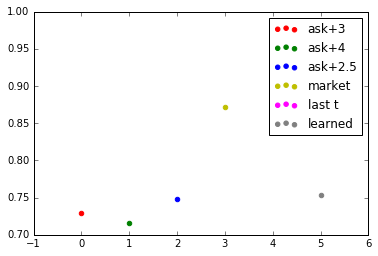

{'ask+2.5': 0.7875749985722834,
 'ask+3': 0.7467529008764506,
 'ask+4': 0.7007717952289351,
 'last t': 0.9148492939242323,
 'learned': 0.7428570497308258,
 'market': 0.9350829213618693}

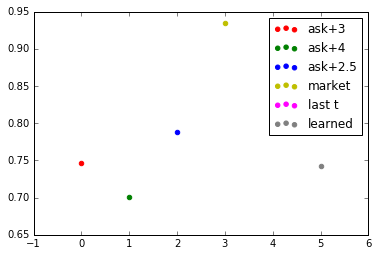

{'ask+2.5': 0.3279882107109007,
 'ask+3': 0.32483297271726363,
 'ask+4': 0.3808990494927793,
 'last t': 0.5759268326956055,
 'learned': 0.3507974399145921,
 'market': 0.4994908397958058}

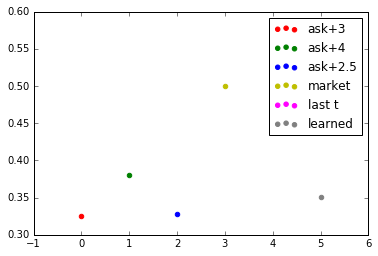

{'ask+2.5': 0.35051820942924933,
 'ask+3': 0.3468350574096094,
 'ask+4': 0.34394618374897873,
 'last t': 0.5628532770501221,
 'learned': 0.34396880388385676,
 'market': 0.6391910418060176}

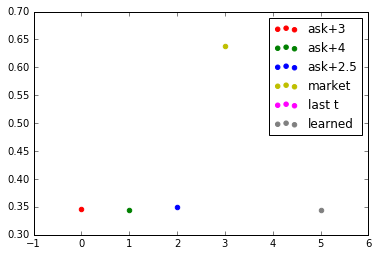

{'ask+2.5': 0.3780180927233828,
 'ask+3': 0.37394127933303456,
 'ask+4': 0.3831532689639255,
 'last t': 1.060585249702907,
 'learned': 0.48644526547007316,
 'market': 0.5261085981349644}

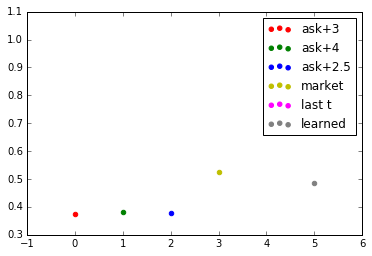

{'ask+2.5': 0.2889629514850382,
 'ask+3': 0.2889625497475497,
 'ask+4': 0.286065690637477,
 'last t': 0.6351471875348584,
 'learned': 0.31893729382381125,
 'market': 0.7083469117538611}

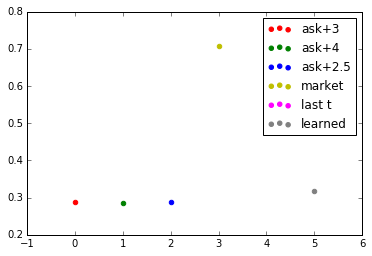

{'ask+2.5': 0.24045530940324822,
 'ask+3': 0.240455028666279,
 'ask+4': 0.2399134167444903,
 'last t': 0.6312897309180041,
 'learned': 0.2986386190949447,
 'market': 0.6561020121036528}

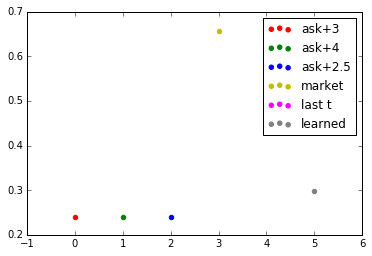

{'ask+2.5': 0.270640772705613,
 'ask+3': 0.3321607456142106,
 'ask+4': 0.36603082468865655,
 'last t': 0.5909405671487925,
 'learned': 0.24034718306716762,
 'market': 0.8259538566032282}

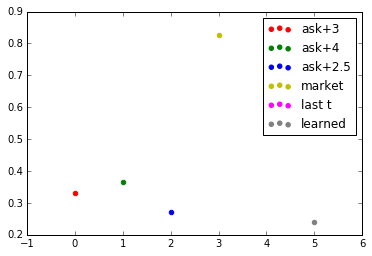

{'ask+2.5': 0.31890748601530483,
 'ask+3': 0.28901232802974763,
 'ask+4': 0.31130898822335973,
 'last t': 0.7240537261463382,
 'learned': 0.39484922837015435,
 'market': 0.7628493744501131}

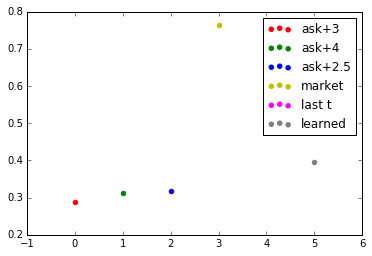

{'ask+2.5': 0.5613164474545671,
 'ask+3': 0.38505916601819745,
 'ask+4': 0.40272588283637456,
 'last t': 0.9385904016052169,
 'learned': 0.5034947471897008,
 'market': 0.862643499461582}

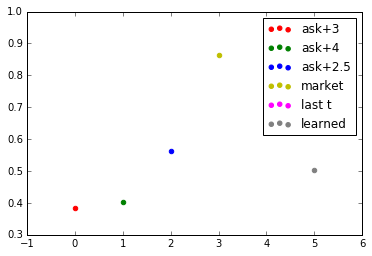

{'ask+2.5': 0.1301960784674652,
 'ask+3': 0.14856481280414857,
 'ask+4': 0.18526805450511608,
 'last t': 0.470845474306153,
 'learned': 0.11537821404166027,
 'market': 0.6188566350443473}

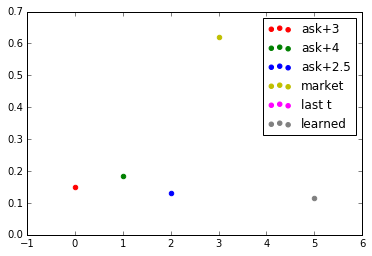

{'ask+2.5': 0.28278499702769466,
 'ask+3': 0.2895482964505474,
 'ask+4': 0.32867482689157607,
 'last t': 0.8026328432504886,
 'learned': 0.3120347124028508,
 'market': 0.6753739171643616}

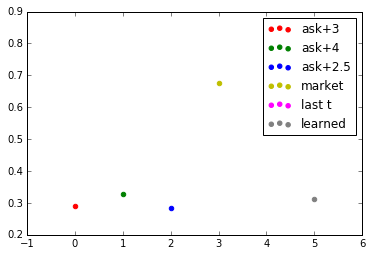

In [66]:
def run_Q(V, H, T, ql, episode_windows):
    costs_list = []
    decisionfrequency = int(H/T)
    print("decisionfrequency:", decisionfrequency)
    ql.epsilon = 0.
    for episode in tqdm(episode_windows[:12]):
        costs = {}
        volume = V
        ots = OrderbookTradingSimulator(orderbooks=episode[:120], volume=volume, tradingperiods=T,
                                        decisionfrequency=decisionfrequency)
        
        for tt in tqdm(range(1, T+1, 1)):
            print("ots.volume", ots.volume)
            new_vol = round_custombase(ots.volume, base=25)    
            if new_vol > 0:
                state = '[{}, {:2d}]'.format(tt,int(new_vol))

                action = ql.chooseAction(state)
                print(state, action)
                obs_ = episode[decisionfrequency * (tt-1):decisionfrequency * tt]
                obs = [elem.copy() for elem in obs_]
                

                center = obs[0].get_center()
                center = ots.masterbook.get_center()
                limit = center + action
            else:
                # theoreticall done
                limit == None

            ots.trade(limit = limit)
            
        print("### Learned strategy ###")
        display(ots.history)
        print("cashflow: {}".format(ots.history.cashflow.sum()))
        print("costs: {}".format(ots.history.cost.sum()))
        costs['learned'] = ots.history.cost.sum()
        
        
        
        lim = episode[0].get_ask() + 4
        print("\n### Fixed limit at: {} (ASK+4) ###".format(lim))
        ots = OrderbookTradingSimulator(orderbooks=episode[:120], volume=volume, tradingperiods=T,
                                        decisionfrequency=decisionfrequency)

        for i in range(T):
            ots.trade(limit = lim)
        #display(ots.history)
        print("cashflow: {}".format(ots.history.cashflow.sum()))
        print("costs: {}".format(ots.history.cost.sum()))
        costs['ask+4'] = ots.history.cost.sum()
        
        
        lim = episode[0].get_ask() + 2.5
        print("\n### Fixed limit at: {} (ASK+2.5) ###".format(lim))
        ots = OrderbookTradingSimulator(orderbooks=episode[:120], volume=volume, tradingperiods=T,
                                        decisionfrequency=decisionfrequency)
        for i in range(T):
            ots.trade(limit = lim)
        #display(ots.history)
        print("cashflow: {}".format(ots.history.cashflow.sum()))
        print("costs: {}".format(ots.history.cost.sum()))
        costs['ask+2.5'] = ots.history.cost.sum()
        
        lim = episode[0].get_ask() + 3
        print("\n### Fixed limit at: {} (ASK+3) ###".format(lim))
        ots = OrderbookTradingSimulator(orderbooks=episode[:120], volume=volume, tradingperiods=T,
                                        decisionfrequency=decisionfrequency)
        for i in range(T):
            ots.trade(limit = lim)
        #display(ots.history)
        print("cashflow: {}".format(ots.history.cashflow.sum()))
        print("costs: {}".format(ots.history.cost.sum()))
        costs['ask+3'] = ots.history.cost.sum()
        
        
        lim = 1
        print("\n### Trade at last t ###")
        ots = OrderbookTradingSimulator(orderbooks=episode[:120], volume=volume, tradingperiods=T,
                                        decisionfrequency=decisionfrequency)
        for i in range(T):
            ots.trade(limit = lim)
        display(ots.history)
        print("cashflow: {}".format(ots.history.cashflow.sum()))
        print("costs: {}".format(ots.history.cost.sum()))
        costs['last t'] = ots.history.cost.sum()
        
        
        print("\n### Market Order: No limit ###")
        ots = OrderbookTradingSimulator(orderbooks=episode[:120], volume=volume, tradingperiods=T,
                                        decisionfrequency=decisionfrequency)
        ots.trade(limit = None)
        display(ots.history)
        print("cashflow: {}".format(ots.history.cashflow.sum()))
        print("costs: {}".format(ots.history.cost.sum()))
        costs['market'] = ots.history.cost.sum()
        
        print("")
        costs_list.append(costs)
    
    for costs in costs_list:
    
        colors=['r','g','b','y','magenta','grey']

        display(costs)
        for i, key in enumerate(costs):
            plt.scatter(i, costs[key], color=colors[i], label=key)
        plt.legend(loc='best')
        plt.show()
        
    return costs_list
        
print("V: {}".format(V))
print("T: {}".format(T))
print("P: {}".format(P))
costs_list = run_Q(V=100, H=T*P, T=T, ql=ql, episode_windows = episode_windows)

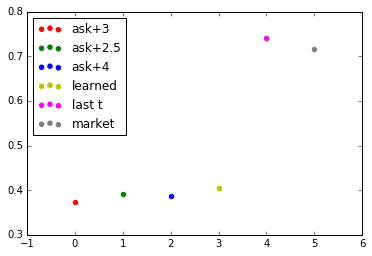

In [67]:
keys = costs_list[0].keys()

avg = {}
for elem in costs_list:
    for key in keys:
        avg[key] = avg.get(key, 0) + elem[key]/len(costs_list)
avg
for i, key in enumerate(avg):
    plt.scatter(i, avg[key], color=colors[i], label=key)
plt.legend(loc='upper left')
plt.show()

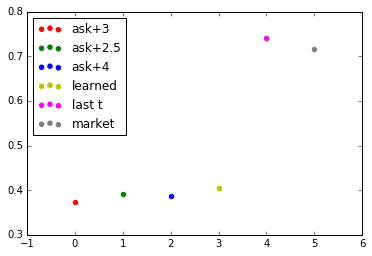

In [68]:
keys = costs_list[0].keys()

avg = {}
for elem in costs_list:
    for key in keys:
        avg[key] = avg.get(key, 0) + elem[key]/len(costs_list)
avg
for i, key in enumerate(avg):
    plt.scatter(i, avg[key], color=colors[i], label=key)
plt.legend(loc='upper left')
plt.show()

In [ ]:
# states:
# [volume_left, time_left]
I = 5
print("V: {}, T: {}, I: {}".format(V, T, I))
volumes_rounded = [I*x for x in range(V/I+1)]
print("volume_left", volumes_rounded)

print(zip(volumes_rounded, range(T)))

states = []
for i in volumes_rounded:
    for j in range(T):
        states.append([i, j])
display(states)

qtable = np.zeros(len(states))
display(qtable, qtable.shape)

qtable[4, ]

display(qtable, qtable.shape)

In [ ]:
def train_RL(V, T, P, epochs, gamma=0.95, DECAY_RATE=0.005, epsilon=1., bufferSize=50, batchSize=30, verbose=False, log=None):
    
    model = base_model()
    if log:
        log = open('logs/RL_train_{}.log'.format(datetime.now().isoformat()[2:-10]), 'w')
        log.write("RL training started\n")
        log.write("Actions: {}\n".format(actions))
        log.write("V={}, T={}, P={}\n".format(V, T, P))
        log.write("Compiled model!")
    MAX_EXPLORATION_RATE = 1.
    MIN_EXPLORATION_RATE = 0.05
    
    min_costs = np.inf

    replay = Memory(bufferSize)
    # stores tuples of (S, A, R, S')

    for i_episode in tqdm(range(epochs)):
        obs = episode_windows[0]  # episode_windows[i]  # Testcase with always the same, identical episode_window

        ots = OrderbookTradingSimulator(volume=V, tradingperiods=T, decisionfrequency=P)

        time_left = T
        volume = V
        action_history = []
        state = np.array([time_left, volume])  # volume])

        acc_cost = 0
        for step in range(T):
            qval = model.predict(state.reshape(1, STATE_DIM))
            # print("     {}".format(qval))

            ob = obs[step*P]
 
            if random.random() < epsilon:
                # choose random action
                #action = random.randint(0, len(actions)-1)
                # action = round(random.random()*2.-1, 1)
                action = random.choice(actions)
            else:
                # choose best action from Q(s,a) values
                action = actions[np.argmin(qval)]
            action_history.append(action)    
            if verbose:
                print("{}: action {}".format(action, actions[action]))
                
            # if V > 0:
            #     best_price = ob.get_ask()
            # elif V < 0:
            #     best_price = ob.get_bid()
            # else:
            #     assert(1 == 2), "Error!"
            # lim = best_price - actions[action]
            
            orderbooks = obs[step*P:(step+1)*P]
            info = ots.trade(orderbooks, agression_factor=action, verbose=False, extrainfo={'ACTION':action})


            time_left -= 1
            volume = ots.volume

            new_state = np.array([time_left, volume])  # volume, 
            cost = ots.history.cost.values[-1]
            if info['forced'].values[0]:
                pass
                # cost *= 3
            acc_cost += cost

            replay.add((state, action, cost, new_state))
            if (replay.size() >= bufferSize):
                # wait for buffer to be filled, before getting started with training
                minibatch = replay.get_random_samples(batchSize)           

                X_train = []
                y_train = []
                for memory in minibatch:
                    state_m, action_m, cost_m, new_state_m = memory

                    qval_old = model.predict(state_m.reshape(1, STATE_DIM))               
                    y = np.zeros((1, NUM_ACTIONS))
                    y[:] = qval_old[:]

                    qval_new_m = model.predict(new_state_m.reshape(1, STATE_DIM), batch_size=1)
                    maxQ = np.max(qval_new_m)

                    update = cost_m + (gamma*maxQ)
                    y[0][action_m] = update  # target output

                    X_train.append(state_m.reshape(STATE_DIM,))
                    y_train.append(y.reshape(NUM_ACTIONS,))
                X_train = np.array(X_train)
                y_train = np.array(y_train)

                # print("Game #: %s" % (i_episode,))
                model.fit(X_train, y_train, batch_size=batchSize, nb_epoch=1, verbose=0)
            state = new_state
            if volume == 0:
                # display(ots.history)
                break

        # reduce exploration rate
        if epsilon > MIN_EXPLORATION_RATE:
            epsilon = MAX_EXPLORATION_RATE *   math.exp(- DECAY_RATE * i_episode)
            
        forced_trade = ""
        if info['forced'].values[0]:
            forced_trade = ", forced!"
        info = "{:4d}/{}: epsilon={:5.3f}, acc_cost: {:0.5f}, steps: {} (t={}) {}\n"\
                .format(i_episode+1, epochs, epsilon,  acc_cost, step, ots.t, forced_trade)
        if log:
            log.write(info)
        if min_costs > acc_cost:
            min_costs = acc_cost
            if log:
                log.write("   {}\n".format(action_history))
            
            print(info)
            print("   {}".format(action_history))
            display(ots.history)
        # print("     {}".format(action_history))
    log.close()

In [ ]:
V=30
T=5
P=2

train_RL(V=V, T=T, P=P, epochs=300, verbose=False, log=True)

In [ ]:
visualize_Q(model, actions, V, T)

In [ ]:
def run(V, T, P, epochs=1, overwrite_actions=None):
    for i_episode in range(epochs):
        obs = episode_windows[0]  # episode_windows[i]  # Testcase with always the same, identical episode_window

        ots = OrderbookTradingSimulator(volume=V, tradingperiods=T, decisionfrequency=P)

        time_left = P*T
        volume = V

        state = np.array([time_left, volume])  # , volume])
        # state = discretize_state(state)

        acc_cost = 0
        for step in range(T):
            qval = model.predict(state.reshape(1, STATE_DIM))
            
            action = actions[np.argmin(qval)]
            
            if overwrite_actions and step < len(overwrite_actions):
                action = overwrite_actions[step]

            ob = obs[step*P]

            orderbooks = obs[step*P:(step+1)*P]
            # info = ots.trade(orderbooks, limit=lim, verbose=False)
            info = ots.trade(orderbooks, agression_factor=action, verbose=False, extrainfo={'ACTION':action})

            time_left -= 1
            volume = ots.volume
            new_state = np.array([time_left, volume])  # , volume])
            cost = ots.history.cost.values[-1]

            acc_cost += cost

            state = new_state
            if volume == 0:
                break

        info = "{:4d}/{}: acc_cost: {:0.5f}, steps: {} (t={})"\
                .format(i_episode+1, epochs, acc_cost, step, ots.t)
        print(info)
    return ots.history
hist = run(V=V, T=T, P=P)  #, overwrite_actions=[0,0,0,0,0,0,0,0,0])
display(hist)
hist = run(V=V, T=T, P=P, overwrite_actions=[0.24]*10)
display(hist)

In [ ]:
plot_episode(episode_windows[3], volume=50, figsize=(5,3))
episode_windows[3][90].plot(range_factor=1.015, figsize=(5,3))

In [ ]:
def show_plots(x):
    # episode_windows[3][x].plot(range_factor=1.015, figsize=(5,3))
    return x

from ipywidgets import interact
interact(show_plots, x=5)

In [ ]:
print(len(obs))
for vol in [1, 50, 100]:
    market_order_price = []
    ask_price = []
    for i, ob in enumerate(obs):
        market_order_price.append(ob.get_current_price(volume=vol))
        ask_price.append(vol*ob.get_ask())

    plt.plot(market_order_price, color='blue', marker='o', label='market order price')
    plt.plot(ask_price, color='red', marker='*', label='ask price')
                         
                         
    
    plt.title("Market order price for {} shares".format(vol))
    plt.ylabel("price")
    plt.xlabel("time")
    plt.legend(loc='best')
    plt.xlim((-1,21))
    plt.show()